In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt
from monty.serialization import loadfn

Function to create models

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, RobustScaler

In [3]:
def run_models(X_train, y_train, X_test, y_test, log_transform=False):
    
#     if log_transform:
#         y_train = np.exp(y_train)
#         y_test = np.exp(y_test)
#         y_pred_train = np.exp(y_pred_train)
#         y_pred_test = np.exp(y_pred_test)
        
    reg = LinearRegression().fit(X_train,y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    
    
    if log_transform:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train = np.exp(y_pred_train)
        y_pred_test = np.exp(y_pred_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    print("Training RMSE: ", rmse_train)
    print("Test RMSE: ", rmse_test)
    print("Mean % Train Error: ", mape_train)
    print("Mean % Test Error: ", mape_test)
    
    if type(y_test) == pd.Series:
        min_t = y_test.min()
        max_t = y_test.max()
    else:
        min_t = y_test.min()[0]
        max_t = y_test.max()[0]

    plt.scatter(y_test, y_pred_test)
    plt.plot([0, max_t], [0, max_t], color="red")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. True Values")
    plt.show()
    
    

    k_fold = 5
    l1_ratios = [i/20 for i in range(1, 21)]
    max_iter = 1000000
    random_state = 1
    test_size = 2
    tol = 0.0001

    models = []
    y_pred_trains = []
    y_pred_tests = []
    train_rmses = []
    test_rmses = []
    train_mapes = []
    test_mapes = []

    for l1_ratio in l1_ratios:
        elasticnetcv = ElasticNetCV(
            fit_intercept=True,
            normalize=False,
            alphas=None,
            cv=k_fold,
            l1_ratio=l1_ratio,
            max_iter=max_iter,
        )

        if log_transformation:
            y_train = np.log(y_train)
            y_test = np.log(y_test)

        elasticnetcv.fit(X_train, y_train.values.ravel())

        elasticnet = ElasticNet(
            fit_intercept=True,
            normalize=False,
            l1_ratio=elasticnetcv.l1_ratio_,
            alpha=elasticnetcv.alpha_,
            max_iter=max_iter,
        )

        elasticnet.fit(X_train, y_train.values.ravel())
        y_pred_train_en = elasticnet.predict(X_train)
        y_pred_test_en = elasticnet.predict(X_test)

        if log_transformation:
            y_train = np.exp(y_train)
            y_test = np.exp(y_test)
            y_pred_train_en = np.exp(y_pred_train_en)
            y_pred_test_en = np.exp(y_pred_test_en)

        rmse_train_en = np.sqrt(mean_squared_error(y_train, y_pred_train_en))
        rmse_test_en = np.sqrt(mean_squared_error(y_test, y_pred_test_en))
        mape_train_en = mean_absolute_percentage_error(y_train, y_pred_train_en)
        mape_test_en = mean_absolute_percentage_error(y_test, y_pred_test_en)

        models.append(elasticnet)
        y_pred_trains.append(y_pred_train_en)
        y_pred_tests.append(y_pred_test_en)
        train_rmses.append(rmse_train_en)
        test_rmses.append(rmse_test_en)
        train_mapes.append(mape_train_en)
        test_mapes.append(mape_test_en)

    best_model_index = test_rmses.index(min(test_rmses))

    elasticnet = models[best_model_index]
    y_pred_train_en = y_pred_trains[best_model_index]
    y_pred_test_en = y_pred_tests[best_model_index]
    rmse_train_en = train_rmses[best_model_index]
    rmse_test_en = test_rmses[best_model_index]
    mape_train_en = train_mapes[best_model_index]
    mape_test_en = test_mapes[best_model_index]
    l1_ratio = l1_ratios[best_model_index]

    print("Elastic Net Model")
    print("l1_ratio =", l1_ratio)
    print("Test RMSE: ", rmse_test_en)
    print("Test MAPE: ", mape_test_en)
    
    coeffs = np.polyfit(l1_ratios, test_rmses, 3)
    vals = [coeffs[0]*val**3 + coeffs[1]*val**2 + coeffs[2]*val + coeffs[3] for val in l1_ratios]

    plt.scatter(l1_ratios, test_rmses)
    plt.plot(l1_ratios, vals)
    plt.title("Test RMSE by Ridge/Lasso Ratio")
    plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
    plt.ylabel("Test RMSE");
    plt.show()
    
    #Elastic Net
    
    if type(y_test) == pd.Series:
        min_t = y_test.min()
        max_t = y_test.max()
    else:
        min_t = y_test.min()[0]
        max_t = y_test.max()[0]

    plt.scatter(y_test, y_pred_test_en)
    plt.plot([0, max_t], [0, max_t], color="red")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. True Values (EN)")
    
    return [rmse_test, rmse_test_en, mape_test, mape_test_en], [y_pred_test, y_pred_test_en], elasticnet

In [4]:
def calc_diff(y_test, y_preds):
    y_lin = []
    for y in y_preds[0]:
        y_lin.append(y[0])
    y_lin_diff = np.exp(y_test.squeeze()).subtract(pd.Series(y_lin, index=y_test.index))

    y_en_diff = np.exp(y_test.squeeze()).subtract(pd.Series(y_preds[1], index=y_test.index))
    print(y_lin_diff)
    print("\n")
    print(y_en_diff)
    
    return y_lin_diff, y_en_diff

In [5]:
results_df = pd.DataFrame()

In [208]:
# Select desired values for booleans:

#Set to True if using charge_throughput as response variable, False if using cycle life (X.capacity_0.8)
ct = True

#True if training on old data and testing on new data, false if mixing both old and new data into train and test set
#Only applies to when old and new data are combined
train_old_test_new = False

#True if including 'X.integrated_time_temperature_cycles_1:100' to full model, False if not
integrated_time_temp_cycles = True

#True if applying a log transformtion to combined data, False if no transformation
log_transformation = True

#True if including internal resistance for old data, false if not (no internal resistance variable for new data)
ir = True

#True if standardizing explanatory variables, false otherwise (necessary for elastic net)
standardized = True

#True if combining both the old data and new data
mix = True

#True if including Environemnt conditions (T, DOD, Ch-Dsch-rate)
environ = False

dataset = True

### Set Up

In [209]:
path = ""
# old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")

In [210]:
# old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [211]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference']
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5']

if integrated_time_temp_cycles:
    full_model_features.append('X.integrated_time_temperature_cycles_1:100')

if ir:
    full_model_features.append('X.min_internal_resistance_cycles_2:100')
    full_model_features.append('X.internal_resistance_difference_cycles_2:100')


if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [212]:
if standardized:
    
    all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))
    if environ:
        all_model_features = all_model_features + ['Temperature', 'DOD', 'Discharge_rate', 'Charge_rate']
        discharge_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))
        full_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))

    def standardize(X_train, X_test, var=False):
        scaler = RobustScaler()
        if var: 
            scaled_X_train = scaler.fit_transform(np.array(X_train).reshape(-1,1))
            X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=[X_train.name])
            scaled_X_test = scaler.transform(np.array(X_test).reshape(-1,1))
            X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=[X_test.name])
        else:
            scaled_X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
            scaled_X_test = scaler.transform(X_test)
            X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)
        return X_train, X_test

#     old_ct[all_model_features] = standardize(old_ct[all_model_features])   

In [213]:
cond = pd.Series({"ct": ct, "train_old_t_new": train_old_test_new, "time_temp_cycle":integrated_time_temp_cycles,
                  "log_y": log_transformation, "ir": ir, "standardized": standardized, "new+old":mix, "environ":environ})

In [214]:
#Removing internal_resistance features for models with new data
if ir:
    full_model_features.remove('X.min_internal_resistance_cycles_2:100')
    full_model_features.remove('X.internal_resistance_difference_cycles_2:100')
    
    if standardized:
        all_model_features.remove('X.min_internal_resistance_cycles_2:100')
        all_model_features.remove('X.internal_resistance_difference_cycles_2:100')

## NCA

In [215]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA_NCA.csv")
source = "NCA"

In [216]:
new_df = pd.read_csv(path + "NewData/NCABatteries.csv")

In [217]:
new_ct["battery_index"] = new_ct["battery"].str[-9:-7].astype(int)

In [218]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [219]:
if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))

In [220]:
train_ind = [0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]
test_ind = [1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23]

In [221]:
new_ct_full["groups"] = 0
new_ct_full.iloc[17, -1] = 1
new_ct_full.groupby("groups").mean()[all_model_features]

,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.slope_discharge_capacity_cycle_number_2:100,X.intercept_discharge_capacity_cycle_number_2:100,X.discharge_capacity_cycle_2,X.charge_time_cycles_1:5,X.integrated_time_temperature_cycles_1:100,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.max_discharge_capacity_difference,X.abs_skew_discharge_capacity_difference_cycles_2:100
groups,,,,,,,,,,
0,0.010774,-1.111981,-0.003798,2.888984,3.101609,1965.634776,510270.239922,0.641640,2.401739,-0.080189
1,-2.595771,-5.250217,-0.005041,0.991732,3.146000,1984.000000,172834.337146,-0.256774,0.000000,-0.124764


In [222]:
new_ct_full["X.battery"]

0       NCA_15C_0-100_0.5-1C_a_CH00_struct
1       NCA_15C_0-100_0.5-1C_b_CH01_struct
2       NCA_15C_0-100_0.5-2C_a_CH02_struct
3       NCA_15C_0-100_0.5-2C_b_CH03_struct
4     NCA_25C_0-100_0.5-0.5C_a_CH04_struct
5     NCA_25C_0-100_0.5-0.5C_b_CH05_struct
6       NCA_25C_0-100_0.5-1C_a_CH06_struct
7       NCA_25C_0-100_0.5-1C_b_CH07_struct
8       NCA_25C_0-100_0.5-1C_c_CH08_struct
9       NCA_25C_0-100_0.5-1C_d_CH09_struct
10      NCA_25C_0-100_0.5-2C_a_CH10_struct
11      NCA_25C_0-100_0.5-2C_b_CH11_struct
12    NCA_25C_20-80_0.5-0.5C_a_CH12_struct
13    NCA_25C_20-80_0.5-0.5C_b_CH13_struct
14    NCA_25C_20-80_0.5-0.5C_c_CH14_struct
15    NCA_25C_20-80_0.5-0.5C_d_CH15_struct
16    NCA_25C_40-60_0.5-0.5C_a_CH16_struct
17    NCA_25C_40-60_0.5-0.5C_b_CH17_struct
18      NCA_35C_0-100_0.5-1C_a_CH18_struct
19      NCA_35C_0-100_0.5-1C_b_CH19_struct
20      NCA_35C_0-100_0.5-1C_c_CH20_struct
21      NCA_35C_0-100_0.5-1C_d_CH21_struct
22      NCA_35C_0-100_0.5-2C_a_CH22_struct
23      NCA

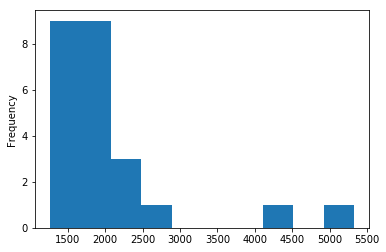

In [223]:
new_ct_full.charge_throughput.plot.hist()

In [224]:
new_ct_full.columns

Index(['X.abs_first_discharge_capacity_difference_cycles_2:100',
       'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
       'X.abs_mean_discharge_capacity_difference_cycles_2:100',
       'X.abs_min_discharge_capacity_difference_cycles_2:100',
       'X.abs_skew_discharge_capacity_difference_cycles_2:100',
       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
       'X.battery_index', 'X.charge_time_cycles_1:5',
       'X.discharge_capacity_cycle_100', 'X.discharge_capacity_cycle_2',
       'X.integrated_time_temperature_cycles_1:100',
       'X.intercept_discharge_capacity_cycle_number_2:100',
       'X.intercept_discharge_capacity_cycle_number_91:100',
       'X.max_discharge_capacity_difference', 'X.max_temperature_cycles_1:100',
       'X.min_temperature_cycles_1:100', 'X.nominal_capacity_by_median',
       'X.slope_discharge_capacity_cycle_number_2:100',
       'X.slope_discharge_capacity_cycle_number_91:100', 'cycle_index',
       'X.capacity_0.83', 

When adding the dropna to the function, it still doesn't save the removal of the NA, but it's still able to standardize the data. After dropping the NA values in their respective X_train and y_train variables, it works like normal but its still chunky

### Variance Model

In [225]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][[variance_model_features]]
X_train_var = X_train_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][[variance_model_features]]
X_test_var = X_test_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_var.index][[y]]

if standardized:
    X_train_var, X_test_var = standardize(
        X_train_var[variance_model_features], 
        X_test_var[variance_model_features], True
    )

model_name = "Variance"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Variance Basic Linear Regression Model
Training RMSE:  644.2360290704827
Test RMSE:  435.7876960284033
Mean % Train Error:  0.23125759135942484
Mean % Test Error:  0.1726125984988723


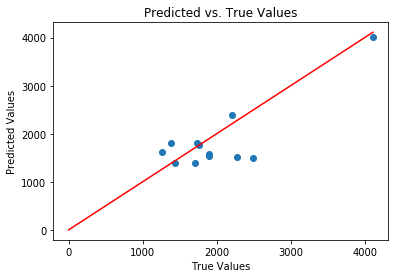

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  756.6013637332499
Test MAPE:  0.20255093198351928


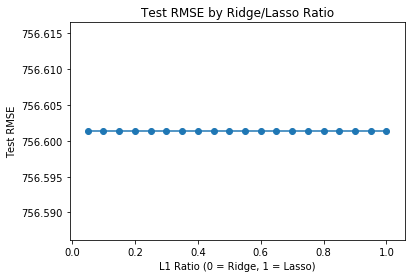

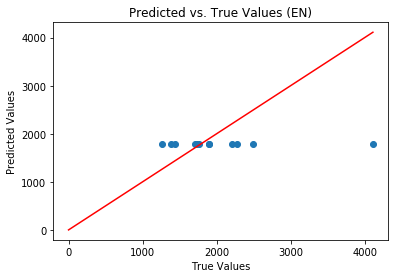

In [226]:
print("Variance Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_var, y_train, X_test_var, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [227]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1     -188.081623
3      301.623072
5       49.182326
7     -423.747764
9      -88.566344
11     324.527935
13     760.960781
15    1002.468933
17     108.982291
19    -359.529168
21     -11.575837
23     363.536432
dtype: float64


1      409.83334
3      -92.88666
5     -361.67466
7     -410.61366
9      -66.50766
11     103.75434
13     481.47134
15     698.31434
17    2315.57834
19    -535.39966
21     -33.21266
23      95.07534
dtype: float64


In [228]:
y_preds[1]

array([1795.78565975, 1795.78565975, 1795.78565975, 1795.78565975,
       1795.78565975, 1795.78565975, 1795.78565975, 1795.78565975,
       1795.78565975, 1795.78565975, 1795.78565975, 1795.78565975])

In [229]:
elasticnet.coef_

array([-8.12445755e-18])

In [230]:
dic = {}
for i in range(len(elasticnet.coef_)):
    print(i)
    dic[list(X_test_var)[i]] = abs(elasticnet.coef_[i])

0


In [231]:
sorted(dic, key = dic.get, reverse=True)

['X.abs_variance_discharge_capacity_difference_cycles_2:100']

In [232]:
X_test_var.columns

Index(['X.abs_variance_discharge_capacity_difference_cycles_2:100'], dtype='object')

### Discharge Model

In [233]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis = X_train_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis = X_test_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(
        X_train_dis[discharge_model_features], 
        X_test_dis[discharge_model_features],
    )

model_name = "Discharge"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  182.023261643762
Test RMSE:  356.4278891390655
Mean % Train Error:  0.08953808817711299
Mean % Test Error:  0.16296974967338196


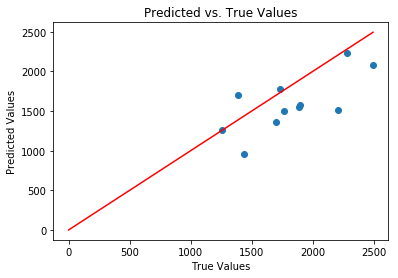

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  369.8240418922929
Test MAPE:  0.1765252592483064


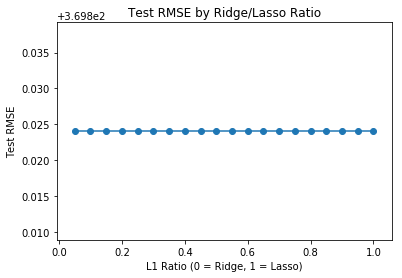

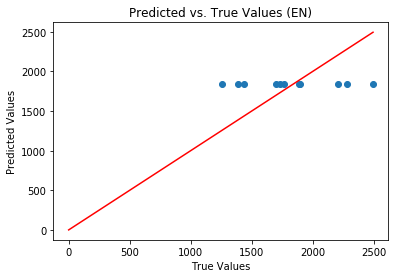

In [234]:
print("Discharge Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_dis, y_train, X_test_dis, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [235]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1     690.230344
3     346.509500
5     479.802908
7    -310.897442
9     -42.485914
11    329.238052
13     39.277186
15    418.539756
19      4.840154
21    260.403123
23    345.456573
dtype: float64


1     363.250329
3    -139.469671
5    -408.257671
7    -457.196671
9    -113.090671
11     57.171329
13    434.888329
15    651.731329
19   -581.982671
21    -79.795671
23     48.492329
dtype: float64


In [236]:
y_preds[1]

array([1842.36867094, 1842.36867094, 1842.36867094, 1842.36867094,
       1842.36867094, 1842.36867094, 1842.36867094, 1842.36867094,
       1842.36867094, 1842.36867094, 1842.36867094])

In [237]:
elasticnet.coef_

array([-4.10912962e-18, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00])

In [238]:
dic = {}
for i in range(len(elasticnet.coef_)):
    dic[list(X_test_dis)[i]] = abs(elasticnet.coef_[i])

In [239]:
sorted(dic, key = dic.get, reverse=True)

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.abs_skew_discharge_capacity_difference_cycles_2:100',
 'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
 'X.discharge_capacity_cycle_2',
 'X.max_discharge_capacity_difference']

In [240]:
X_test_dis.columns

Index(['X.abs_min_discharge_capacity_difference_cycles_2:100',
       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
       'X.abs_skew_discharge_capacity_difference_cycles_2:100',
       'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
       'X.discharge_capacity_cycle_2', 'X.max_discharge_capacity_difference'],
      dtype='object')

Double checking the coefficients

In [241]:
(X_test_dis.loc[1].values)

array([-3.3541713 , -1.98793372, -0.46764092, -1.18614143, -4.31034483,
       -0.02232369])

In [242]:
np.exp((X_test_dis.loc[1].values * elasticnet.coef_).sum() + elasticnet.intercept_)

1842.3686709374379

In [243]:
elasticnet.intercept_

7.518807343877224

### Full Model

In [244]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full = X_train_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full = X_test_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_full.index][[y]]

if standardized:
    X_train_full, X_test_full = standardize(
        X_train_full[full_model_features], 
        X_test_full[full_model_features],
    )

model_name = "Full"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  256.9769498366464
Test RMSE:  575.4223932728794
Mean % Train Error:  0.11259485254107017
Mean % Test Error:  0.21310831079966955


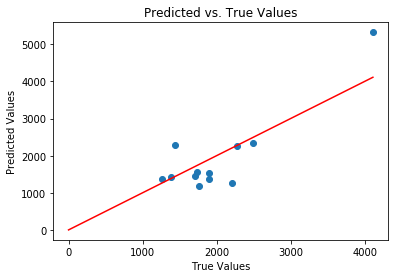

Elastic Net Model
l1_ratio = 1.0
Test RMSE:  290.49822335220153
Test MAPE:  0.12923738251766553


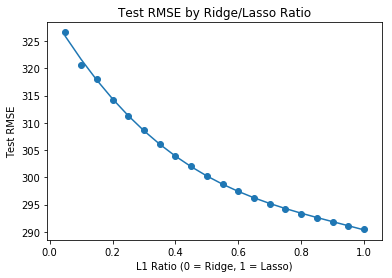

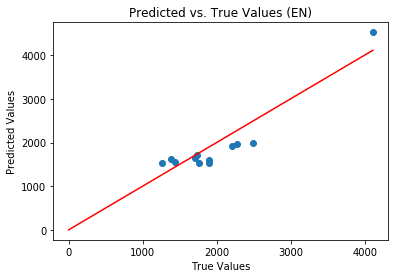

In [245]:
print("Discharge Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_full, y_train, X_test_full, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [246]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1      948.475295
3      237.840547
5     -844.955424
7      -50.520265
9      172.882083
11     536.897864
13      14.068171
15     157.961596
17   -1212.719465
19    -114.986384
21     584.512406
23     363.033415
dtype: float64


1     292.240853
3      49.030721
5    -118.808612
7    -241.943061
9       8.194283
11    296.193495
13    300.371954
15    497.408798
17   -412.035772
19   -276.935566
21    233.773072
23    354.480979
dtype: float64


In [247]:
elasticnet.coef_

array([-0.03745872, -0.        , -0.01992157, -0.13902762,  0.        ,
        0.        , -0.        ])

In [248]:
list(X_test_full)

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.slope_discharge_capacity_cycle_number_2:100',
 'X.intercept_discharge_capacity_cycle_number_2:100',
 'X.discharge_capacity_cycle_2',
 'X.charge_time_cycles_1:5',
 'X.integrated_time_temperature_cycles_1:100']

In [249]:
dic = {}
for i in range(len(elasticnet.coef_)):
    dic[list(X_test_full)[i]] = abs(elasticnet.coef_[i])

In [250]:
sorted(dic, key = dic.get, reverse=True)

['X.intercept_discharge_capacity_cycle_number_2:100',
 'X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.slope_discharge_capacity_cycle_number_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.discharge_capacity_cycle_2',
 'X.charge_time_cycles_1:5',
 'X.integrated_time_temperature_cycles_1:100']

## NMC

In [251]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA_NMC.csv")
source = "NMC"

In [252]:
new_df = pd.read_csv(path + "NewData/NMCBatteries.csv")

In [253]:
new_ct["battery_index"] = new_ct["battery"].str[-9:-7].astype(int)

In [254]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [255]:
(new_ct_full == 0.0).sum(axis=0)

X.abs_first_discharge_capacity_difference_cycles_2:100       0
X.abs_kurtosis_discharge_capacity_difference_cycles_2:100    0
X.abs_mean_discharge_capacity_difference_cycles_2:100        0
X.abs_min_discharge_capacity_difference_cycles_2:100         0
X.abs_skew_discharge_capacity_difference_cycles_2:100        0
X.abs_variance_discharge_capacity_difference_cycles_2:100    0
X.battery_index                                              1
X.charge_time_cycles_1:5                                     0
X.discharge_capacity_cycle_100                               0
X.discharge_capacity_cycle_2                                 0
X.integrated_time_temperature_cycles_1:100                   0
X.intercept_discharge_capacity_cycle_number_2:100            0
X.intercept_discharge_capacity_cycle_number_91:100           0
X.max_discharge_capacity_difference                          7
X.max_temperature_cycles_1:100                               0
X.min_temperature_cycles_1:100                         

In [256]:
new_ct_full.iloc[[16, 17, 18, 19, 20, 21, 22], 8:]

,X.discharge_capacity_cycle_100,X.discharge_capacity_cycle_2,X.integrated_time_temperature_cycles_1:100,X.intercept_discharge_capacity_cycle_number_2:100,X.intercept_discharge_capacity_cycle_number_91:100,X.max_discharge_capacity_difference,X.max_temperature_cycles_1:100,X.min_temperature_cycles_1:100,X.nominal_capacity_by_median,X.slope_discharge_capacity_cycle_number_2:100,...,cycle_index,X.capacity_0.83,X.capacity_0.86,X.capacity_0.89,X.capacity_0.92,X.capacity_0.95,X.capacity_0.98,X.battery,charge_throughput,X.cycle_index
16,1.8,2.969,397114.438257,1.960128,1.800000,0.0,28.639000,24.940001,1.8,-0.002362,...,4350.0,4350.0,4350.0,4350.0,4350.0,4350.0,4350.0,NMC_25C_20-80_0.5-0.5C_a_CH16_struct,6477.410,4350.0
17,1.8,2.980,401200.145837,1.961506,1.800000,0.0,28.976000,25.330000,1.8,-0.002383,...,3630.0,3630.0,3630.0,3630.0,3630.0,3630.0,3630.0,NMC_25C_20-80_0.5-0.5C_b_CH17_struct,5593.483,3630.0
18,1.8,2.985,386951.604195,1.961895,1.800000,0.0,27.719000,24.400999,1.8,-0.002389,...,3359.0,3359.0,3359.0,3359.0,3359.0,3359.0,3359.0,NMC_25C_20-80_0.5-0.5C_d_CH19_struct,5288.438,3359.0
19,1.8,2.982,265601.867476,1.961641,1.798182,0.0,42.401001,25.510000,1.8,-0.002385,...,3609.0,3609.0,3609.0,3609.0,3609.0,3609.0,3609.0,NMC_25C_20-80_0.5-3C_a_CH20_struct,5150.006,3609.0
20,0.6,2.988,158659.825859,0.927062,0.600000,0.0,28.655001,24.158001,0.6,-0.004825,...,11149.0,11149.0,11149.0,11149.0,11149.0,11149.0,11149.0,NMC_25C_40-60_0.5-0.5C_a_CH22_struct,6971.787,11149.0
21,0.6,2.952,122964.302108,0.922963,0.600000,0.0,41.819000,26.830999,0.6,-0.004765,...,12918.0,12918.0,12918.0,12918.0,12918.0,12918.0,12918.0,NMC_25C_40-60_0.5-3C_a_CH24_struct,8109.346,12918.0
22,0.6,2.965,120319.760978,0.924265,0.600000,0.0,40.529999,26.301001,0.6,-0.004784,...,11148.0,11148.0,11148.0,11148.0,11148.0,11148.0,11148.0,NMC_25C_40-60_0.5-3C_b_CH25_struct,6965.715,11148.0


In [257]:
if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))

In [258]:
train_ind = [0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
test_ind = [1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27]
#switched b/c 18 has nans so we want more in train rather than test

In [259]:
# new_ct_full["groups"] = 0
# new_ct_full.iloc[11, -1] = 11
# new_ct_full.iloc[17, -1] = 17
# new_ct_full.iloc[21, -1] = 21

# new_ct_full.replace([np.inf, -np.inf], np.nan).dropna(axis=0).groupby("groups").mean()[all_model_features]

In [260]:
new_ct_full["X.battery"]

0       NMC_15C_0-100_0.5-1C_a_CH00_struct
1       NMC_15C_0-100_0.5-1C_b_CH01_struct
2       NMC_15C_0-100_0.5-2C_a_CH02_struct
3       NMC_15C_0-100_0.5-2C_b_CH03_struct
4     NMC_25C_0-100_0.5-0.5C_a_CH04_struct
5     NMC_25C_0-100_0.5-0.5C_b_CH05_struct
6       NMC_25C_0-100_0.5-1C_a_CH06_struct
7       NMC_25C_0-100_0.5-1C_b_CH07_struct
8       NMC_25C_0-100_0.5-1C_c_CH08_struct
9       NMC_25C_0-100_0.5-1C_d_CH09_struct
10      NMC_25C_0-100_0.5-2C_a_CH10_struct
11      NMC_25C_0-100_0.5-2C_b_CH11_struct
12      NMC_25C_0-100_0.5-3C_a_CH12_struct
13      NMC_25C_0-100_0.5-3C_b_CH13_struct
14      NMC_25C_0-100_0.5-3C_c_CH14_struct
15      NMC_25C_0-100_0.5-3C_d_CH15_struct
16    NMC_25C_20-80_0.5-0.5C_a_CH16_struct
17    NMC_25C_20-80_0.5-0.5C_b_CH17_struct
18    NMC_25C_20-80_0.5-0.5C_d_CH19_struct
19      NMC_25C_20-80_0.5-3C_a_CH20_struct
20    NMC_25C_40-60_0.5-0.5C_a_CH22_struct
21      NMC_25C_40-60_0.5-3C_a_CH24_struct
22      NMC_25C_40-60_0.5-3C_b_CH25_struct
23      NMC

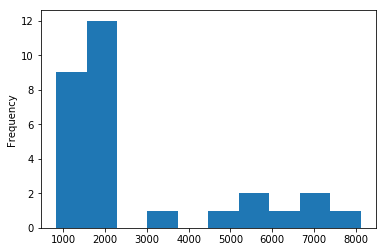

In [261]:
new_ct_full.charge_throughput.plot.hist()

### Variance Model

In [262]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][[variance_model_features]]
X_train_var = X_train_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][[variance_model_features]]
X_test_var = X_test_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_var.index][[y]]

if standardized:
    X_train_var, X_test_var = standardize(
        X_train_var[variance_model_features], 
        X_test_var[variance_model_features], True
    )

model_name = "Variance"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Variance Basic Linear Regression Model
Training RMSE:  1664.647355341507
Test RMSE:  1490.910517917905
Mean % Train Error:  0.38431295539894444
Mean % Test Error:  0.38698539439296914


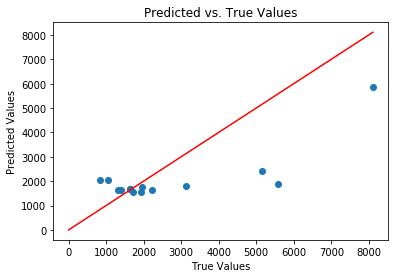

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  1493.7684675719283
Test MAPE:  0.38733368185819417


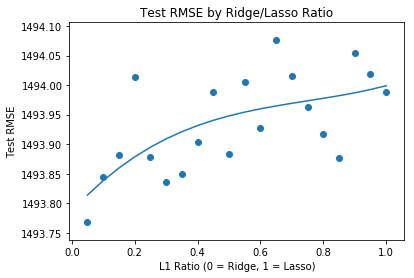

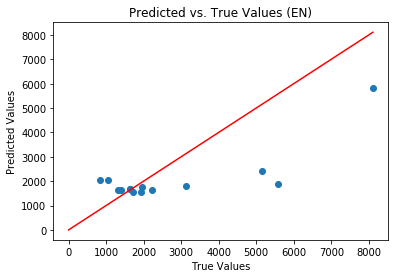

In [263]:
print("Variance Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_var, y_train, X_test_var, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [264]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1     -979.125419
3    -1231.616373
5      132.681236
7      389.038370
9     -310.166186
11    1308.896243
13    -261.724305
15     591.129683
17    3700.480634
19    2726.544347
21    2253.729966
23     -42.782628
25     -49.560349
27     190.643865
dtype: float64


1     -979.584341
3    -1231.921813
5      130.469120
7      386.712756
9     -312.178420
11    1307.569509
13    -263.661727
15     589.157123
17    3699.441862
19    2727.981729
21    2281.018753
23     -44.664752
25     -51.381629
27     189.157412
dtype: float64


In [265]:
elasticnet.coef_

array([-0.19065151])

In [266]:
list(X_test_var)

['X.abs_variance_discharge_capacity_difference_cycles_2:100']

In [267]:
dic = {}
for i in range(len(elasticnet.coef_)):
    dic[list(X_test_var)[i]] = abs(elasticnet.coef_[i])

In [268]:
sorted(dic, key = dic.get, reverse=True)

['X.abs_variance_discharge_capacity_difference_cycles_2:100']

### Discharge Model

In [269]:
X_test_dis[discharge_model_features].replace(-np.inf, np.nan).dropna(axis=0)

,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference
1,-3.354171,-1.987934,-0.467641,-1.186141,-4.310345,-0.022324
3,1.275018,1.252089,-0.564369,-1.033262,-4.206897,-0.387620
5,1.514024,1.323095,-0.321745,-1.181195,0.224138,0.306443
7,-0.247358,-0.292999,0.483926,0.822046,-0.431034,0.155251
9,-1.955083,-0.322779,0.570794,0.731977,-0.120690,0.228311
11,0.525086,0.544856,-0.869921,-0.310826,-0.500000,-0.076104
13,0.724166,0.774746,-1.260875,-0.616186,0.344828,-1.273465
15,0.714717,0.873984,-1.275185,-0.992984,-0.827586,-1.308980
19,-0.156414,0.374759,-0.172135,-0.457070,0.137931,0.300355
21,-0.263343,-0.175556,0.214489,0.467538,1.034483,0.324708


In [270]:
X_test_dis

,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference
1,-3.354171,-1.987934,-0.467641,-1.186141,-4.310345,-0.022324
3,1.275018,1.252089,-0.564369,-1.033262,-4.206897,-0.387620
5,1.514024,1.323095,-0.321745,-1.181195,0.224138,0.306443
7,-0.247358,-0.292999,0.483926,0.822046,-0.431034,0.155251
9,-1.955083,-0.322779,0.570794,0.731977,-0.120690,0.228311
11,0.525086,0.544856,-0.869921,-0.310826,-0.500000,-0.076104
13,0.724166,0.774746,-1.260875,-0.616186,0.344828,-1.273465
15,0.714717,0.873984,-1.275185,-0.992984,-0.827586,-1.308980
19,-0.156414,0.374759,-0.172135,-0.457070,0.137931,0.300355
21,-0.263343,-0.175556,0.214489,0.467538,1.034483,0.324708


In [271]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis = X_train_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis = X_test_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(
        X_train_dis[discharge_model_features], 
        X_test_dis[discharge_model_features],
    )

model_name = "Discharge"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  218.134988487415
Test RMSE:  764.0056598968538
Mean % Train Error:  0.11255450475337202
Mean % Test Error:  0.28090301644973514


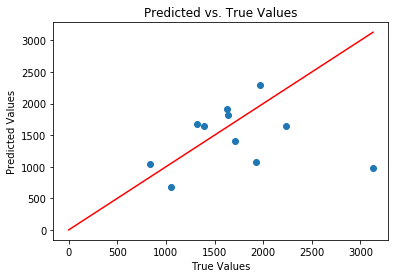

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  638.0795210926531
Test MAPE:  0.21459912809178733


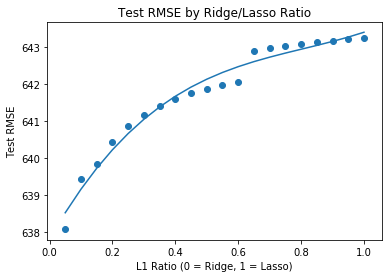

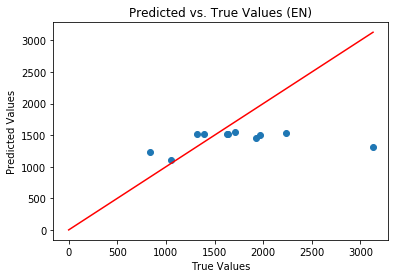

In [272]:
print("Discharge Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_dis, y_train, X_test_dis, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [273]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1      377.895610
3     -205.888845
5      298.469791
7      854.596882
9     -360.735151
11    2154.401761
13    -256.525109
15     597.328818
23    -293.067184
25    -175.659394
27    -324.357112
dtype: float64


1      -49.216231
3     -399.097405
5      152.238405
7      468.775573
9     -191.590169
11    1813.329571
13    -127.685212
15     704.714940
23     109.702014
25     115.079274
27     459.235044
dtype: float64


In [274]:
elasticnet.coef_

array([ 0.        ,  0.        , -0.        , -0.        ,  0.03231963,
        0.        ])

In [275]:
list(X_test_dis)

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.abs_skew_discharge_capacity_difference_cycles_2:100',
 'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
 'X.discharge_capacity_cycle_2',
 'X.max_discharge_capacity_difference']

In [276]:
dic = {}
for i in range(len(elasticnet.coef_)):
    dic[list(X_test_dis)[i]] = abs(elasticnet.coef_[i])

In [277]:
sorted(dic, key = dic.get, reverse=True)

['X.discharge_capacity_cycle_2',
 'X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.abs_skew_discharge_capacity_difference_cycles_2:100',
 'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
 'X.max_discharge_capacity_difference']

### Full Model

In [278]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full = X_train_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full = X_test_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_full.index][[y]]

if standardized:
    X_train_full, X_test_full = standardize(
        X_train_full[full_model_features], 
        X_test_full[full_model_features],
    )

model_name = "Full"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  262.3859316175854
Test RMSE:  1073.0314152659998
Mean % Train Error:  0.10580498982178972
Mean % Test Error:  0.19793022790796724


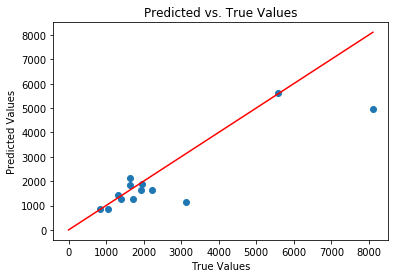

Elastic Net Model
l1_ratio = 0.35
Test RMSE:  549.4221356322083
Test MAPE:  0.1535830836926528


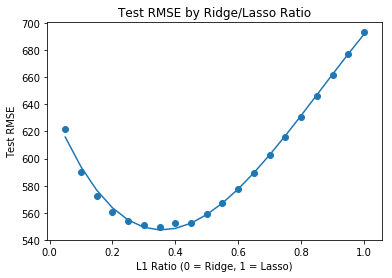

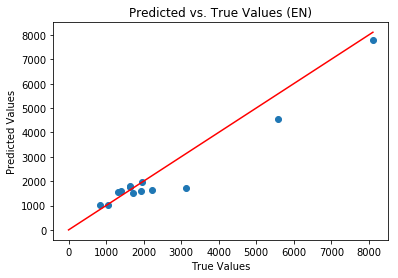

In [279]:
print("Discharge Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_full, y_train, X_test_full, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [280]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1      191.250227
3      -40.592778
5      442.429638
7      275.102372
9     -108.531875
11    1991.103472
13     110.228666
15     606.002214
17     -27.544174
21    3162.223283
23    -499.447382
25    -218.649927
27      71.918114
dtype: float64


1       33.333412
3     -178.729025
5      199.120011
7      349.135512
9     -244.688213
11    1423.081479
13    -196.322612
15     616.144081
17    1045.882894
21     306.607270
23    -164.766047
25    -106.318109
27     -10.077931
dtype: float64


In [281]:
elasticnet.coef_

array([-0.05393588, -0.03451968,  0.18678036, -0.23746707,  0.08570321,
        0.02644808, -0.        ])

In [282]:
list(X_test_full)

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.slope_discharge_capacity_cycle_number_2:100',
 'X.intercept_discharge_capacity_cycle_number_2:100',
 'X.discharge_capacity_cycle_2',
 'X.charge_time_cycles_1:5',
 'X.integrated_time_temperature_cycles_1:100']

In [283]:
dic = {}
for i in range(len(elasticnet.coef_)):
    dic[list(X_test_full)[i]] = abs(elasticnet.coef_[i])

In [284]:
sorted(dic, key = dic.get, reverse=True)

['X.intercept_discharge_capacity_cycle_number_2:100',
 'X.slope_discharge_capacity_cycle_number_2:100',
 'X.discharge_capacity_cycle_2',
 'X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.charge_time_cycles_1:5',
 'X.integrated_time_temperature_cycles_1:100']

## LFP

In [285]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")
source = "LFP"

In [286]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

In [287]:
new_ct["battery_index"] = new_ct["battery"].str[-2:].astype(int)

In [288]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [289]:
if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))

In [290]:
train_ind = [0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
test_ind = [1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [291]:
# new_ct_full["groups"] = 0
# new_ct_full.iloc[11, -1] = 11
# new_ct_full.iloc[15, -1] = 15
# new_ct_full.iloc[19, -1] = 19

# new_ct_full.replace([np.inf, -np.inf], np.nan).dropna(axis=0).groupby("groups")[all_model_features].describe().iloc[:, :16]

In [292]:
new_ct_full["X.battery"]

0       LFP_15C_0-100_0.5-1C_a_CH00
1       LFP_15C_0-100_0.5-1C_a_CH01
2       LFP_15C_0-100_0.5-1C_a_CH02
3       LFP_15C_0-100_0.5-1C_a_CH03
4       LFP_15C_0-100_0.5-1C_a_CH04
5       LFP_15C_0-100_0.5-1C_a_CH05
6       LFP_15C_0-100_0.5-1C_a_CH06
7       LFP_15C_0-100_0.5-1C_a_CH07
8       LFP_15C_0-100_0.5-1C_a_CH08
9       LFP_15C_0-100_0.5-1C_a_CH09
10      LFP_15C_0-100_0.5-1C_a_CH10
11      LFP_15C_0-100_0.5-1C_a_CH11
12      LFP_15C_0-100_0.5-1C_a_CH12
13      LFP_15C_0-100_0.5-1C_a_CH13
14      LFP_15C_0-100_0.5-1C_a_CH14
15    LFP_25C_20-80_0.5-0.5C_a_CH15
16    LFP_25C_20-80_0.5-0.5C_b_CH16
17    LFP_25C_20-80_0.5-0.5C_c_CH17
18    LFP_25C_20-80_0.5-0.5C_d_CH18
19      LFP_25C_20-80_0.5-3C_a_CH19
20    LFP_25C_40-60_0.5-0.5C_a_CH20
21    LFP_25C_40-60_0.5-0.5C_b_CH21
22      LFP_25C_40-60_0.5-3C_a_CH22
23      LFP_25C_40-60_0.5-3C_b_CH23
24      LFP_35C_0-100_0.5-1C_a_CH24
25      LFP_35C_0-100_0.5-1C_b_CH25
26      LFP_35C_0-100_0.5-1C_c_CH26
27      LFP_35C_0-100_0.5-1C

Nothing specific to initial conditions

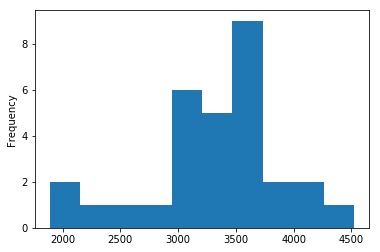

In [293]:
new_ct_full.charge_throughput.plot.hist()

### Variance Model

In [294]:
# Variance model
X_train_var = new_ct_full.iloc[train_ind][[variance_model_features]]
X_train_var = X_train_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][[variance_model_features]]
X_test_var = X_test_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_var.index][[y]]

if standardized:
    X_train_var, X_test_var = standardize(
        X_train_var[variance_model_features], 
        X_test_var[variance_model_features], True
    )

model_name = "Variance"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Variance Basic Linear Regression Model
Training RMSE:  633.3641870392685
Test RMSE:  533.8799941071768
Mean % Train Error:  0.16333549567476238
Mean % Test Error:  0.1485460356461938


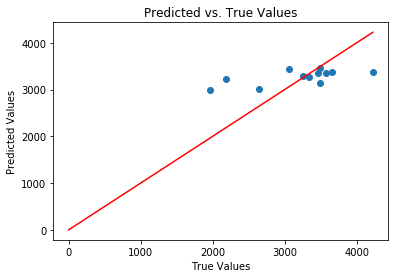

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  641.1629571298948
Test MAPE:  0.17638325984555317


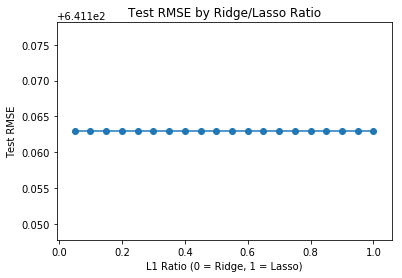

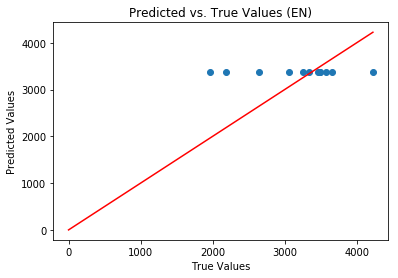

In [295]:
print("Variance Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_var, y_train, X_test_var, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [296]:
results_df

,EN_mape,EN_rmse,L_mape,L_rmse,coef,ct,data,environ,ir,log_y,model,new+old,standardized,time_temp_cycle,train_old_t_new,source_v
0,0.202551,756.601364,0.172613,435.787696,[-8.12445755357174e-18],1.0,NCA,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
1,0.151340,321.745791,0.330654,724.418249,"[-0.052398868048105764, -0.0, -0.0, -0.0, 0.0,...",1.0,NCA,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
2,0.201796,706.649367,0.507998,1149.765440,"[-0.007374690818696963, -0.0, -0.0, -0.0, 0.0,...",1.0,NCA,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
3,0.387334,1493.768468,0.386985,1490.910518,[-0.19065150630020095],1.0,NMC,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
4,0.195836,615.954509,0.241999,693.530273,"[0.0, -0.0, 0.0, 0.0, 0.029086967804971935, 0....",1.0,NMC,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
5,0.159628,555.837900,0.207779,1362.525761,"[-0.030931559001205502, -0.024145899755950155,...",1.0,NMC,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
6,0.176383,641.162957,0.148546,533.879994,[0.0],1.0,LFP,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
7,0.128313,487.012917,0.435354,2101.922985,"[0.0711628404993017, -0.0, -0.0762756249351698...",1.0,LFP,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
8,0.116586,561.132427,0.447694,1956.670634,"[0.08165635734541497, 0.14563245030628708, -0....",1.0,LFP,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
9,0.493960,682.233425,0.505741,679.441792,[4.212861725379188e-18],1.0,NCA+OLD,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,1.0


In [297]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1      219.151246
3      285.598127
5       25.541479
7     -384.109926
9      114.404168
11     844.509892
13     -33.468338
15     337.393714
17      81.612080
19   -1026.385553
21   -1047.435665
23    -379.550509
dtype: float64


1      204.060147
3      281.486147
5      112.284147
7     -312.494853
9       96.111147
11     851.411147
13    -125.276853
15     111.065147
17     -28.797853
19   -1412.837853
21   -1185.844853
23    -732.534853
dtype: float64


In [298]:
elasticnet.coef_

array([0.])

In [299]:
list(X_test_var)

['X.abs_variance_discharge_capacity_difference_cycles_2:100']

In [300]:
dic = {}
for i in range(len(elasticnet.coef_)):
    dic[list(X_test_var)[i]] = abs(elasticnet.coef_[i])

In [301]:
sorted(dic, key = dic.get, reverse=True)

['X.abs_variance_discharge_capacity_difference_cycles_2:100']

### Discharge Model

In [302]:
# discharge model
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis = X_train_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis = X_test_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(
        X_train_dis[discharge_model_features], 
        X_test_dis[discharge_model_features],
    )

model_name = "Discharge"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  268.1961972973718
Test RMSE:  513.2174808232901
Mean % Train Error:  0.05494566510069288
Mean % Test Error:  0.12518978436683115


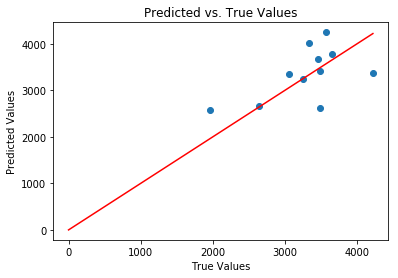

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  491.9843554806311
Test MAPE:  0.12949773063833658


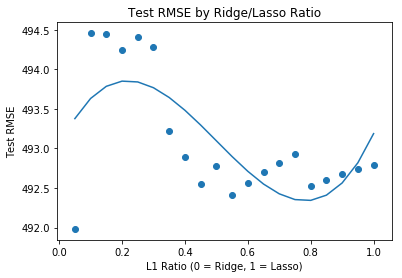

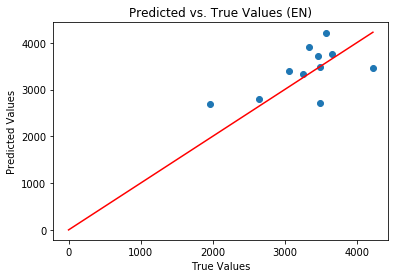

In [303]:
print("Discharge Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_dis, y_train, X_test_dis, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [304]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1    -675.529829
3    -135.252544
5      61.874791
7    -302.150203
9    -211.897388
11    852.438187
13      8.040383
15    851.737754
17   -676.761662
19   -609.502244
23    -31.375550
dtype: float64


1    -632.696659
3    -112.225379
5       6.227754
7    -330.717393
9    -254.796248
11    765.561919
13    -88.914740
15    765.262597
17   -573.157029
19   -737.328583
23   -153.365627
dtype: float64


In [305]:
elasticnet.coef_

array([ 0.07512112, -0.        , -0.08629382,  0.21447706, -0.00399947,
       -0.0240971 ])

In [306]:
list(X_test_dis)

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.abs_skew_discharge_capacity_difference_cycles_2:100',
 'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
 'X.discharge_capacity_cycle_2',
 'X.max_discharge_capacity_difference']

In [307]:
dic = {}
for i in range(len(elasticnet.coef_)):
    dic[list(X_test_dis)[i]] = abs(elasticnet.coef_[i])

In [308]:
sorted(dic, key = dic.get, reverse=True)

['X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
 'X.abs_skew_discharge_capacity_difference_cycles_2:100',
 'X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.max_discharge_capacity_difference',
 'X.discharge_capacity_cycle_2',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100']

### Full Model

In [309]:
# full model
X_train_full = new_ct_full.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full = X_train_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full = X_test_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = new_ct_full.iloc[X_test_full.index][[y]]

if standardized:
    X_train_full, X_test_full = standardize(
        X_train_full[full_model_features], 
        X_test_full[full_model_features],
    )

model_name = "Full"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  75.53310902087496
Test RMSE:  855.7755886961475
Mean % Train Error:  0.01785260612438322
Mean % Test Error:  0.22789554613988436


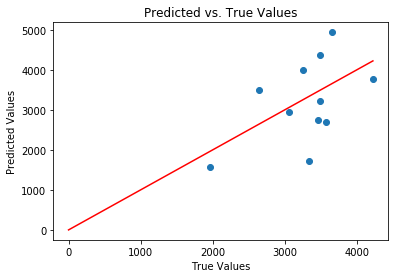

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  625.8253937369188
Test MAPE:  0.15977023340011395


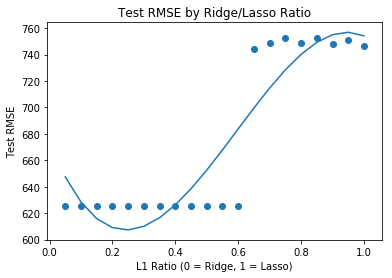

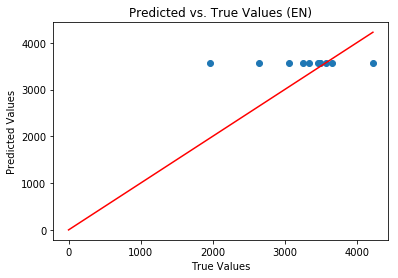

In [310]:
print("Discharge Basic Linear Regression Model")
rmses, y_preds, elasticnet = run_models(X_train_full, y_train, X_test_full, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [311]:
y_lin_diff, y_en_diff = calc_diff(y_test, y_preds)

1      886.291451
3    -1285.895359
5     -874.461596
7      102.944194
9      718.427498
11     458.202545
13    -750.305614
15     250.858328
17    1616.655577
19     389.793288
23    -850.917339
dtype: float64


1       10.604291
3       88.030291
5      -81.171709
7     -505.950709
9      -97.344709
11     657.955291
13    -318.732709
15     -82.390709
17    -222.253709
19   -1606.293709
23    -925.990709
dtype: float64


In [312]:
elasticnet.coef_

array([ 0.,  0.,  0.,  0., -0., -0., -0.])

In [313]:
list(X_test_full)

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.slope_discharge_capacity_cycle_number_2:100',
 'X.intercept_discharge_capacity_cycle_number_2:100',
 'X.discharge_capacity_cycle_2',
 'X.charge_time_cycles_1:5',
 'X.integrated_time_temperature_cycles_1:100']

In [314]:
dic = {}
for i in range(len(elasticnet.coef_)):
    dic[list(X_test_full)[i]] = abs(elasticnet.coef_[i])

In [315]:
sorted(dic, key = dic.get, reverse=True)

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.slope_discharge_capacity_cycle_number_2:100',
 'X.intercept_discharge_capacity_cycle_number_2:100',
 'X.discharge_capacity_cycle_2',
 'X.charge_time_cycles_1:5',
 'X.integrated_time_temperature_cycles_1:100']

In [316]:
results_df

,EN_mape,EN_rmse,L_mape,L_rmse,coef,ct,data,environ,ir,log_y,model,new+old,standardized,time_temp_cycle,train_old_t_new,source_v
0,0.202551,756.601364,0.172613,435.787696,[-8.12445755357174e-18],1.0,NCA,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
1,0.151340,321.745791,0.330654,724.418249,"[-0.052398868048105764, -0.0, -0.0, -0.0, 0.0,...",1.0,NCA,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
2,0.201796,706.649367,0.507998,1149.765440,"[-0.007374690818696963, -0.0, -0.0, -0.0, 0.0,...",1.0,NCA,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
3,0.387334,1493.768468,0.386985,1490.910518,[-0.19065150630020095],1.0,NMC,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
4,0.195836,615.954509,0.241999,693.530273,"[0.0, -0.0, 0.0, 0.0, 0.029086967804971935, 0....",1.0,NMC,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
5,0.159628,555.837900,0.207779,1362.525761,"[-0.030931559001205502, -0.024145899755950155,...",1.0,NMC,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
6,0.176383,641.162957,0.148546,533.879994,[0.0],1.0,LFP,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
7,0.128313,487.012917,0.435354,2101.922985,"[0.0711628404993017, -0.0, -0.0762756249351698...",1.0,LFP,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
8,0.116586,561.132427,0.447694,1956.670634,"[0.08165635734541497, 0.14563245030628708, -0....",1.0,LFP,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
9,0.493960,682.233425,0.505741,679.441792,[4.212861725379188e-18],1.0,NCA+OLD,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,1.0


In [317]:
results_df[results_df.data == "LFP"]

,EN_mape,EN_rmse,L_mape,L_rmse,coef,ct,data,environ,ir,log_y,model,new+old,standardized,time_temp_cycle,train_old_t_new,source_v
6,0.176383,641.162957,0.148546,533.879994,[0.0],1.0,LFP,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
7,0.128313,487.012917,0.435354,2101.922985,"[0.0711628404993017, -0.0, -0.0762756249351698...",1.0,LFP,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
8,0.116586,561.132427,0.447694,1956.670634,"[0.08165635734541497, 0.14563245030628708, -0....",1.0,LFP,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
27,0.176383,641.162957,0.148546,533.879994,[0.0],1.0,LFP,0.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
28,0.129498,491.984355,0.125190,513.217481,"[0.07512112076536587, -0.0, -0.086293822045679...",1.0,LFP,0.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
29,0.159770,625.825394,0.227896,855.775589,"[0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0]",1.0,LFP,0.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN


In [318]:
list(X_test_full.columns) + ["Temp", "DOD", "Ch-Ds-rate"]

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.slope_discharge_capacity_cycle_number_2:100',
 'X.intercept_discharge_capacity_cycle_number_2:100',
 'X.discharge_capacity_cycle_2',
 'X.charge_time_cycles_1:5',
 'X.integrated_time_temperature_cycles_1:100',
 'Temp',
 'DOD',
 'Ch-Ds-rate']

In [319]:
results_df.loc[[2, 5, 8], "coef"].values

array([array([-0.00737469, -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ]),
       array([-0.03093156, -0.0241459 ,  0.15167539, -0.11412386,  0.05026763,
        0.        , -0.        ,  0.01259951, -0.18906821,  0.        ,
        0.        ]),
       array([ 0.08165636,  0.14563245, -0.04440235, -0.01696223, -0.11718654,
       -0.22157174, -0.10694284,  0.18324349, -0.11313753, -0.16934075,
        0.        ])], dtype=object)

In [320]:
# pd.DataFrame(results_df.loc[[2, 5, 8], "coef"].to_list(), columns=list(X_test_full.columns) + ["Temp", "DOD", "Ch-Ds-rate"])

In [321]:
# results_df

In [322]:
# coefs_full = (pd.DataFrame(results_df[results_df.model == "Full"].loc[:, "coef"].to_list(),
#                            columns = full_model_features))# + ["X.integrated_time_temperature_cycles_1:100"]))
# coefs_full["data"] = results_df[results_df.model == "Full"].loc[:, "data"].reset_index().drop("index", axis=1)
# coefs_full["EN_mape"] = results_df[results_df.model == "Full"].loc[:, "EN_mape"].reset_index().drop("index", axis=1)

In [323]:
# coefs_full

In [324]:
# coefs_dis = (pd.DataFrame(results_df[results_df.model == "Discharge"].loc[:, "coef"].to_list(),
#                            columns = discharge_model_features))# + ["X.integrated_time_temperature_cycles_1:100"]))
# coefs_dis["data"] = results_df[results_df.model == "Discharge"].loc[:, "data"].reset_index().drop("index", axis=1)
# coefs_dis["EN_mape"] = results_df[results_df.model == "Discharge"].loc[:, "EN_mape"].reset_index().drop("index", axis=1)

In [325]:
# coefs_dis.drop(index=[3, 4, 5], axis=0)

In [326]:
# stop

In [327]:
if dataset:
    discharge_model_features.append("Source")
    full_model_features.append("Source")
    all_model_features.append("Source")

## NCA + OLD DATA

In [328]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA_NCA.csv")
new_df = pd.read_csv(path + "NewData/NCABatteries.csv")

In [329]:
new_ct["battery_index"] = new_ct["battery"].str[-9:-7].astype(int)

In [330]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [331]:
if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))
    new_ct_full["Source"] = 1

In [332]:
new_ct_full.head(5)

,X.abs_first_discharge_capacity_difference_cycles_2:100,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.abs_mean_discharge_capacity_difference_cycles_2:100,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.battery_index,X.charge_time_cycles_1:5,X.discharge_capacity_cycle_100,X.discharge_capacity_cycle_2,...,cycle_index,X.capacity_0.83,X.capacity_0.86,X.capacity_0.89,X.capacity_0.92,X.capacity_0.95,X.capacity_0.98,X.battery,charge_throughput,X.cycle_index
0,-0.581882,0.091227,-0.652902,-0.556555,-0.198558,-2.537839,0,1920.000000,2.619,2.911,...,521.0,257.0,190.0,144.0,108.0,77.0,38.0,NCA_15C_0-100_0.5-1C_a_CH00_struct,1261.478,521.0
1,-0.718078,0.089352,-0.821970,-0.705399,-0.252584,-2.727858,1,1920.000000,2.662,2.895,...,257.0,257.0,257.0,232.0,156.0,102.0,49.0,NCA_15C_0-100_0.5-1C_b_CH01_struct,2205.619,917.0
2,-0.705683,0.852673,-1.107777,0.148826,0.321565,-1.115799,2,1971.199951,2.543,2.870,...,255.0,205.0,158.0,119.0,91.0,69.0,47.0,NCA_15C_0-100_0.5-2C_a_CH02_struct,1841.362,915.0
3,-0.600825,0.183003,-1.070569,0.414443,-0.334105,-0.100452,3,1996.800049,2.560,2.901,...,783.0,233.0,175.0,130.0,94.0,69.0,45.0,NCA_15C_0-100_0.5-2C_b_CH03_struct,1702.899,783.0
4,-0.835342,0.101538,-0.537124,0.230440,0.188283,-0.195601,4,1984.000000,2.901,3.161,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NCA_25C_0-100_0.5-0.5C_a_CH04_struct,1354.915,512.0


In [333]:
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
old_ct["Source"] = -1

In [334]:
if environ:
    old_ct["Temperature"] = 30
    old_ct["DOD"] = 100
    old_ct["Discharge_rate"] = 4
    old_ct["Charge_rate"] = 4.8

In [335]:
old_ct.head()

,Unnamed: 0,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_mean_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,...,X.capacity_0.83,cycle_index,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap,charge_throughput,Source
0,0,1.045426,0.889146,1.033181,231072.426367,614.400024,-1.144416,-1.470437,-3.014024,-1.090972,...,467,483,el150800440551,2017-06-30_tests\20170630-4_4C_55per_6C.sdu,18,0.98,0.78,0.03,486.255859,-1
1,1,1.062025,0.489706,1.043915,149767.851320,563.200012,-1.277359,-1.607566,-3.263050,-2.111475,...,668,668,el150800737229,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,15,0.98,0.78,0.03,659.681458,-1
2,2,1.067879,0.496145,1.054091,205315.487728,614.400024,-1.375239,-1.698837,-3.451007,-1.762625,...,774,774,el150800737366,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,29,0.98,0.78,0.03,776.911377,-1
3,3,1.051274,0.490112,1.034198,159799.489005,563.200012,-1.243089,-1.547185,-3.174008,-1.041141,...,543,543,el150800737234,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,37,0.98,0.78,0.03,535.996155,-1
4,4,1.066573,0.475715,1.069509,146029.525036,614.400024,-1.640444,-2.032966,-4.054918,-0.570989,...,1011,1011,el150800737329,2018-04-12_batch8\20180412-5C_67per_4C_newstru...,9,0.98,0.78,0.03,1048.040771,-1


In [336]:
full_df = old_ct.append(new_ct_full, ignore_index=True)
#full_data = full_data.reset_index()

In [337]:
full_df.head()

,Unnamed: 0,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_mean_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,...,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap,charge_throughput,Source,X.battery_index,X.battery,X.cycle_index
0,0.0,1.045426,0.889146,1.033181,231072.426367,614.400024,-1.144416,-1.470437,-3.014024,-1.090972,...,2017-06-30_tests\20170630-4_4C_55per_6C.sdu,18.0,0.98,0.78,0.03,486.255859,-1.0,NaN,NaN,NaN
1,1.0,1.062025,0.489706,1.043915,149767.851320,563.200012,-1.277359,-1.607566,-3.263050,-2.111475,...,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,15.0,0.98,0.78,0.03,659.681458,-1.0,NaN,NaN,NaN
2,2.0,1.067879,0.496145,1.054091,205315.487728,614.400024,-1.375239,-1.698837,-3.451007,-1.762625,...,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,29.0,0.98,0.78,0.03,776.911377,-1.0,NaN,NaN,NaN
3,3.0,1.051274,0.490112,1.034198,159799.489005,563.200012,-1.243089,-1.547185,-3.174008,-1.041141,...,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,37.0,0.98,0.78,0.03,535.996155,-1.0,NaN,NaN,NaN
4,4.0,1.066573,0.475715,1.069509,146029.525036,614.400024,-1.640444,-2.032966,-4.054918,-0.570989,...,2018-04-12_batch8\20180412-5C_67per_4C_newstru...,9.0,0.98,0.78,0.03,1048.040771,-1.0,NaN,NaN,NaN


In [338]:
full_df.columns

Index(['Unnamed: 0', 'X.discharge_capacity_cycle_2',
       'X.max_discharge_capacity_difference', 'X.discharge_capacity_cycle_100',
       'X.integrated_time_temperature_cycles_1:100',
       'X.charge_time_cycles_1:5',
       'X.abs_min_discharge_capacity_difference_cycles_2:100',
       'X.abs_mean_discharge_capacity_difference_cycles_2:100',
       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
       'X.abs_skew_discharge_capacity_difference_cycles_2:100',
       'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
       'X.abs_first_discharge_capacity_difference_cycles_2:100',
       'X.max_temperature_cycles_1:100', 'X.min_temperature_cycles_1:100',
       'X.slope_discharge_capacity_cycle_number_2:100',
       'X.intercept_discharge_capacity_cycle_number_2:100',
       'X.slope_discharge_capacity_cycle_number_91:100',
       'X.intercept_discharge_capacity_cycle_number_91:100',
       'X.min_internal_resistance_cycles_2:100',
       'X.internal_resistance

In [339]:
#True if combining both the old data and new data
mix = True

train_old_test_new = False
source = "NCA+OLD"

cond = pd.Series({"ct": ct, "train_old_t_new": train_old_test_new, "time_temp_cycle":integrated_time_temp_cycles,
                  "log_y": log_transformation, "ir": ir, "standardized": standardized, "new+old":mix, "environ": environ, 
                  "source_v":dataset})

In [340]:
if train_old_test_new:
    train_ind = [i for i in range(1,139)]
    test_ind = [j for j in range(140,163)]
    
else:
    train_ind = [i for i in range(0, 163, 2)]
    test_ind = [i for i in range(1, 163, 2)]
#     train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
#             35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
#             69, 71, 73, 75, 77, 79, 81]
#     test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
#             34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
#             68, 70, 72, 74, 76, 78, 80, 82, 83]

#     train_ind = train_ind + list(range(old_ct.shape[0],old_ct.shape[0] + new_ct.shape[0], 2))
#     test_ind = test_ind + list(range(old_ct.shape[0] + 1,old_ct.shape[0] + new_ct.shape[0], 2))

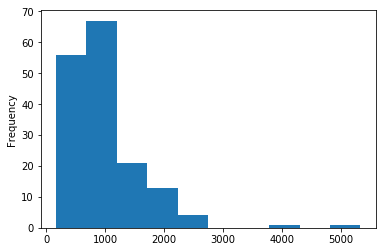

In [341]:
full_df.charge_throughput.plot.hist()

### Variance Model

In [342]:
# Variance model
X_train_var = full_df.iloc[train_ind][[variance_model_features]]
X_train_var = X_train_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_var.index][[y]]

X_test_var = full_df.iloc[test_ind][[variance_model_features]]
X_test_var = X_test_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_var.index][[y]]

if standardized:
    X_train_var, X_test_var = standardize(
        X_train_var[variance_model_features], 
        X_test_var[variance_model_features], True
    )

model_name = "Variance"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Variance Basic Linear Regression Model
Training RMSE:  576.2702882445932
Test RMSE:  679.441791767345
Mean % Train Error:  0.3877929752274058
Mean % Test Error:  0.5057413742204196


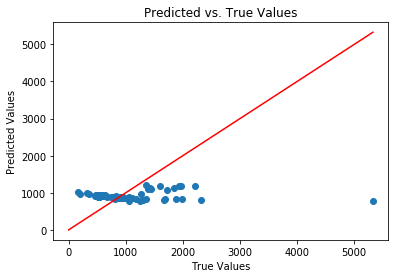

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  682.2334253588123
Test MAPE:  0.4939596992180125


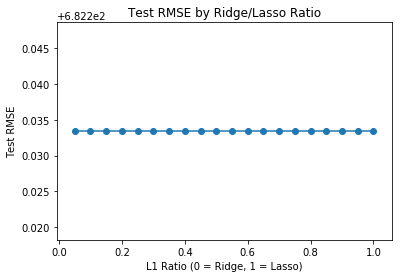

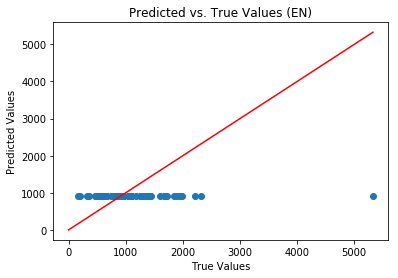

In [343]:
print("Variance Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_var, y_train, X_test_var, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

### Discharge Model

In [344]:
# discharge model
X_train_dis = full_df.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis = X_train_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_dis.index][[y]]

X_test_dis = full_df.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis = X_test_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_dis.index][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(
        X_train_dis[discharge_model_features], 
        X_test_dis[discharge_model_features],
    )

model_name = "Discharge"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  164.94268862237732
Test RMSE:  187.2174467758388
Mean % Train Error:  0.10184386359190781
Mean % Test Error:  0.13098116916143496


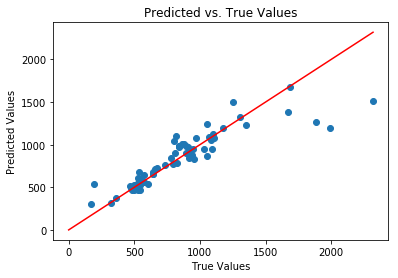

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  187.930815155003
Test MAPE:  0.1275807071366481


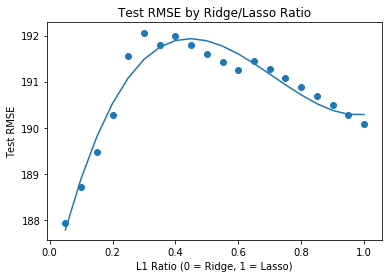

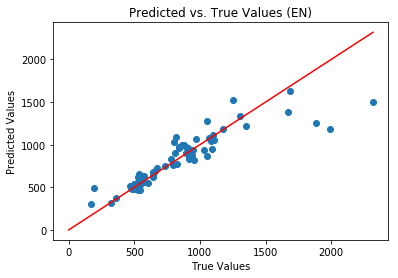

In [345]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_dis, y_train, X_test_dis, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

### Full Model

In [346]:
# full model
X_train_full = full_df.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full = X_train_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_full.index][[y]]

X_test_full = full_df.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full = X_test_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_full.index][[y]]

if standardized:
    X_train_full, X_test_full = standardize(
        X_train_full[full_model_features], 
        X_test_full[full_model_features],
    )

model_name = "Full"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  159.7040551502267
Test RMSE:  179.7322726802279
Mean % Train Error:  0.09965322421513169
Mean % Test Error:  0.13195139114415821


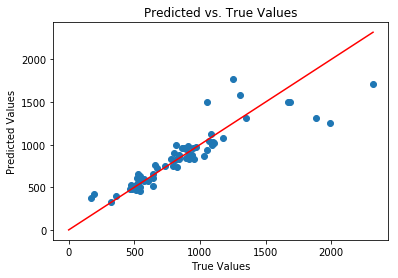

Elastic Net Model
l1_ratio = 0.1
Test RMSE:  180.14459339348133
Test MAPE:  0.1269302266845538


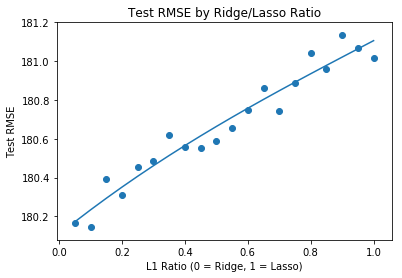

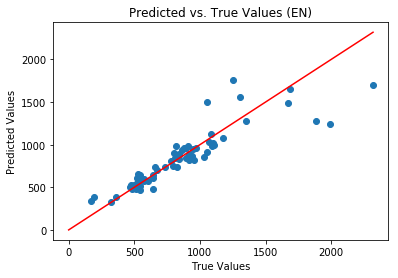

In [347]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_full, y_train, X_test_full, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [348]:
path = ""
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [349]:
old_ct['metadata.protocol_x'].apply(lambda x: x.split("_")[0]).unique()

array(['2017-06-30', '2018-04-12', '2017-05-12'], dtype=object)

In [350]:
old_ct.iloc[:5, 23]

0          2017-06-30_tests\20170630-4_4C_55per_6C.sdu
1    2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...
2    2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...
3    2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...
4    2018-04-12_batch8\20180412-5C_67per_4C_newstru...
Name: metadata.protocol_x, dtype: object

In [351]:
for i in old_ct.iloc[:, 23].sample(5):
    print(i)

2017-06-30_tests\20170630-3_6C_2per_4_85C.sdu
2018-04-12_batch8\20180412-4_8C_80per_4_8C_newstructure.sdu
2017-05-12_TESTS\20170512-8C-25PER_3_6C.SDU
2017-06-30_tests\20170630-4_8C_80per_4_8C.sdu
2017-05-12_TESTS\20170512-6C-50PER_3_6C.SDU


## NMC + OLD DATA

In [352]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA_NMC.csv")
new_df = pd.read_csv(path + "NewData/NMCBatteries.csv")

In [353]:
new_ct["battery_index"] = new_ct["battery"].str[-9:-7].astype(int)

In [354]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
new_ct_full["Source"] = 1

In [355]:
if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))

In [356]:
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
old_ct["Source"] = -1

In [357]:
if environ:
    old_ct["Temperature"] = 30
    old_ct["DOD"] = 100
    old_ct["Charge_rate"] = 4.8
    old_ct["Discharge_rate"] = 4

In [358]:
full_df = old_ct.append(new_ct_full, ignore_index=True)
#full_data = full_data.reset_index()

In [359]:
full_df.head()

,Unnamed: 0,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_mean_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,...,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap,charge_throughput,Source,X.battery_index,X.battery,X.cycle_index
0,0.0,1.045426,0.889146,1.033181,231072.426367,614.400024,-1.144416,-1.470437,-3.014024,-1.090972,...,2017-06-30_tests\20170630-4_4C_55per_6C.sdu,18.0,0.98,0.78,0.03,486.255859,-1,NaN,NaN,NaN
1,1.0,1.062025,0.489706,1.043915,149767.851320,563.200012,-1.277359,-1.607566,-3.263050,-2.111475,...,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,15.0,0.98,0.78,0.03,659.681458,-1,NaN,NaN,NaN
2,2.0,1.067879,0.496145,1.054091,205315.487728,614.400024,-1.375239,-1.698837,-3.451007,-1.762625,...,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,29.0,0.98,0.78,0.03,776.911377,-1,NaN,NaN,NaN
3,3.0,1.051274,0.490112,1.034198,159799.489005,563.200012,-1.243089,-1.547185,-3.174008,-1.041141,...,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,37.0,0.98,0.78,0.03,535.996155,-1,NaN,NaN,NaN
4,4.0,1.066573,0.475715,1.069509,146029.525036,614.400024,-1.640444,-2.032966,-4.054918,-0.570989,...,2018-04-12_batch8\20180412-5C_67per_4C_newstru...,9.0,0.98,0.78,0.03,1048.040771,-1,NaN,NaN,NaN


In [360]:
#True if combining both the old data and new data
mix = True

source = "NMC+OLD"

cond = pd.Series({"ct": ct, "train_old_t_new": train_old_test_new, "time_temp_cycle":integrated_time_temp_cycles,
                  "log_y": log_transformation, "ir": ir, "standardized": standardized, "new+old":mix, "environ":environ, 
                  "source_v":dataset})

In [361]:
full_df.shape

(168, 49)

In [362]:
if train_old_test_new:
    train_ind = [i for i in range(1,139)]
    test_ind = [j for j in range(140,168)]
    
else:
    train_ind = [i for i in range(0, 168, 2)]
    test_ind = [i for i in range(1, 168, 2)]
#     train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
#             35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
#             69, 71, 73, 75, 77, 79, 81]
#     test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
#             34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
#             68, 70, 72, 74, 76, 78, 80, 82, 83]

#     train_ind = train_ind + list(range(old_ct.shape[0],old_ct.shape[0] + new_ct.shape[0], 2))
#     test_ind = test_ind + list(range(old_ct.shape[0] + 1,old_ct.shape[0] + new_ct.shape[0], 2))

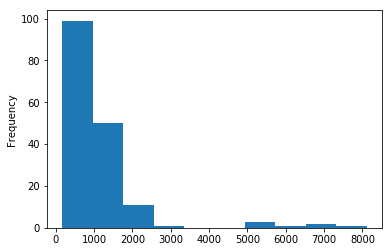

In [363]:
full_df.charge_throughput.plot.hist()

### Variance Model

In [364]:
# Variance model
X_train_var = full_df.iloc[train_ind][[variance_model_features]]
X_train_var = X_train_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_var.index][[y]]

X_test_var = full_df.iloc[test_ind][[variance_model_features]]
X_test_var = X_test_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_var.index][[y]]

if standardized:
    X_train_var, X_test_var = standardize(
        X_train_var[variance_model_features], 
        X_test_var[variance_model_features], True
    )

model_name = "Variance"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Variance Basic Linear Regression Model
Training RMSE:  1104.1393333193187
Test RMSE:  1277.5791522569034
Mean % Train Error:  0.40176540622631984
Mean % Test Error:  0.5368561344216451


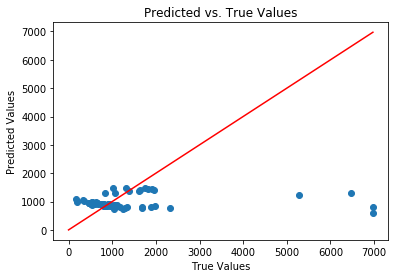

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  1283.4666645597524
Test MAPE:  0.5211032591111687


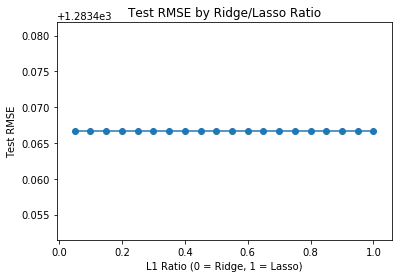

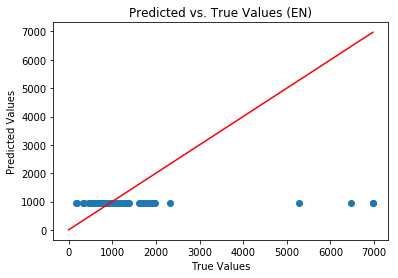

In [365]:
print("Variance Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_var, y_train, X_test_var, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

### Discharge Model

In [366]:
# discharge model
X_train_dis = full_df.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis = X_train_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_dis.index][[y]]

X_test_dis = full_df.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis = X_test_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_dis.index][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(
        X_train_dis[discharge_model_features], 
        X_test_dis[discharge_model_features],
    )

model_name = "Discharge"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  270.3063204734182
Test RMSE:  220.43792157912736
Mean % Train Error:  0.1221447945967594
Mean % Test Error:  0.15941718133029217


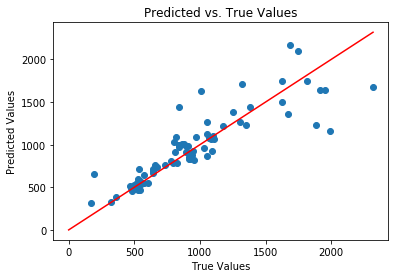

Elastic Net Model
l1_ratio = 1.0
Test RMSE:  241.82523544431137
Test MAPE:  0.17617078872359632


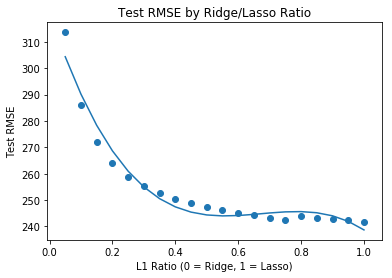

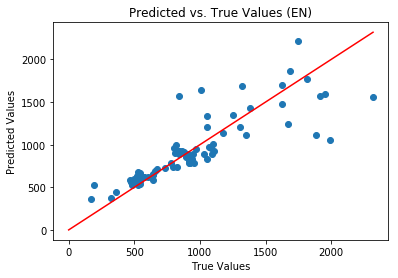

In [367]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_dis, y_train, X_test_dis, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

### Full Model

In [368]:
# full model
X_train_full = full_df.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full = X_train_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_full.index][[y]]

X_test_full = full_df.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full = X_test_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_full.index][[y]]

if standardized:
    X_train_full, X_test_full = standardize(
        X_train_full[full_model_features], 
        X_test_full[full_model_features],
    )

model_name = "Full"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  221.88489535442375
Test RMSE:  688.5081181708201
Mean % Train Error:  0.14538036077246608
Mean % Test Error:  0.18246422291203868


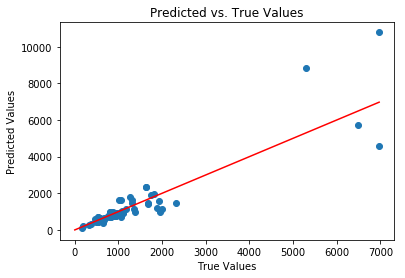

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  425.34036561140175
Test MAPE:  0.21226883935068375


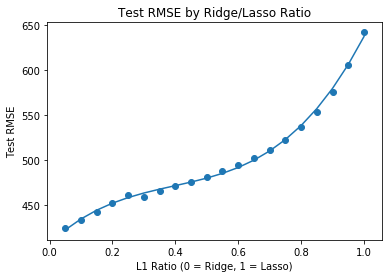

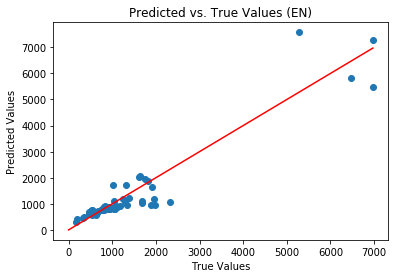

In [369]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_full, y_train, X_test_full, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

## LFP + OLD DATA

In [370]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

In [371]:
new_ct["battery_index"] = new_ct["battery"].str[-2:].astype(int)

In [372]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
new_ct_full["Source"] = 1

In [373]:
if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))

In [374]:
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
old_ct["Source"] = -1

In [375]:
if environ:
    old_ct["Temperature"] = 30
    old_ct["DOD"] = 100
    old_ct["Charge_rate"] = 4.8
    old_ct["Discharge_rate"] = 4

In [376]:
full_df = old_ct.append(new_ct_full, ignore_index=True)
#full_data = full_data.reset_index()

In [377]:
full_df.shape

(169, 49)

In [378]:
#True if combining both the old data and new data
mix = True

source = "LFP+OLD"

cond = pd.Series({"ct": ct, "train_old_t_new": train_old_test_new, "time_temp_cycle":integrated_time_temp_cycles,
                  "log_y": log_transformation, "ir": ir, "standardized": standardized, "new+old":mix, "environ":environ, 
                  "source_v":dataset})

In [379]:
if train_old_test_new:
    train_ind = [i for i in range(1,139)]
    test_ind = [j for j in range(140,169)]
    
else:
    train_ind = [i for i in range(0, 84, 2)] + [i for i in range(140, 169, 2)]
    test_ind = [i for i in range(1, 84, 2)] + [i for i in range(141, 169, 2)]
#     train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
#             35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
#             69, 71, 73, 75, 77, 79, 81]
#     test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
#             34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
#             68, 70, 72, 74, 76, 78, 80, 82, 83]

#     train_ind = train_ind + list(range(old_ct.shape[0],old_ct.shape[0] + new_ct.shape[0], 2))
#     test_ind = test_ind + list(range(old_ct.shape[0] + 1,old_ct.shape[0] + new_ct.shape[0], 2))

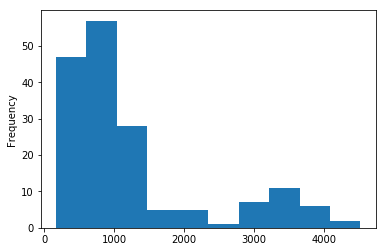

In [380]:
full_df.charge_throughput.plot.hist()

### Variance Model

In [381]:
# Variance model
X_train_var = full_df.iloc[train_ind][[variance_model_features]]
X_train_var = X_train_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_var.index][[y]]

X_test_var = full_df.iloc[test_ind][[variance_model_features]]
X_test_var = X_test_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_var.index][[y]]

if standardized:
    X_train_var, X_test_var = standardize(
        X_train_var[variance_model_features], 
        X_test_var[variance_model_features], True
    )

model_name = "Variance"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Variance Basic Linear Regression Model
Training RMSE:  1078.5304239080215
Test RMSE:  1157.2460339296345
Mean % Train Error:  0.4827796829496807
Mean % Test Error:  0.6239934022238917


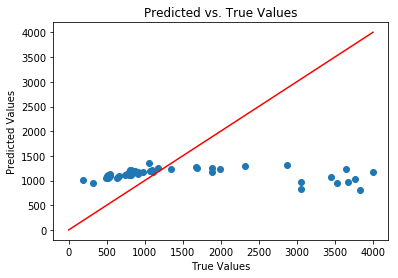

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  1122.9972558089544
Test MAPE:  0.6660283046540251


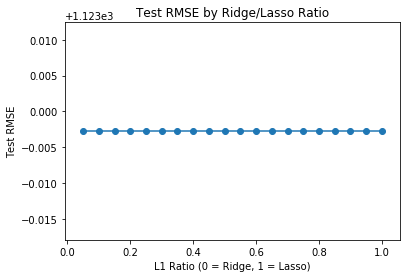

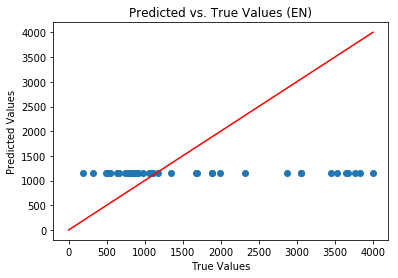

In [382]:
print("Variance Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_var, y_train, X_test_var, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

### Discharge Model

In [383]:
# discharge model
X_train_dis = full_df.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis = X_train_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_dis.index][[y]]

X_test_dis = full_df.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis = X_test_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_dis.index][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(
        X_train_dis[discharge_model_features], 
        X_test_dis[discharge_model_features],
    )

model_name = "Discharge"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  600.2619788242379
Test RMSE:  612.9651380089396
Mean % Train Error:  0.2429076431279006
Mean % Test Error:  0.28086941278356015


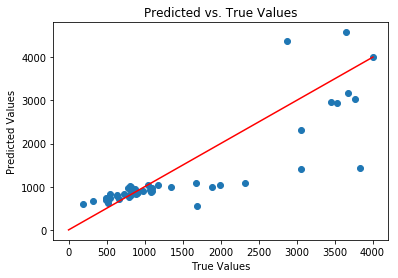

Elastic Net Model
l1_ratio = 0.95
Test RMSE:  555.2240509572312
Test MAPE:  0.29465606616663964


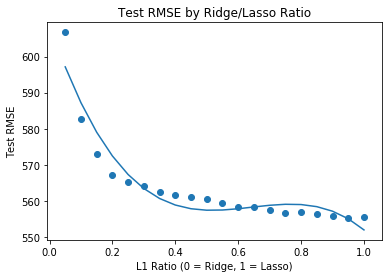

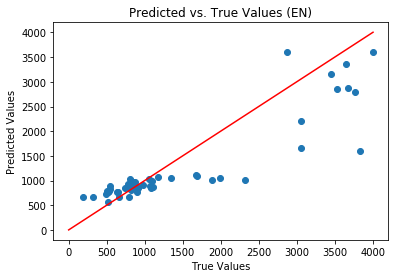

In [384]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_dis, y_train, X_test_dis, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

### Full Model

In [385]:
# full model
X_train_full = full_df.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full = X_train_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = full_df.iloc[X_train_full.index][[y]]

X_test_full = full_df.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full = X_test_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = full_df.iloc[X_test_full.index][[y]]

if standardized:
    X_train_full, X_test_full = standardize(
        X_train_full[full_model_features], 
        X_test_full[full_model_features],
    )

model_name = "Full"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  499.35726250303094
Test RMSE:  647.5377298705672
Mean % Train Error:  0.17129200929369404
Mean % Test Error:  0.24781559329629924


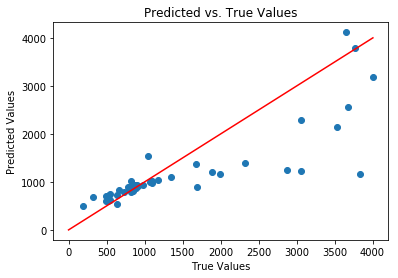

Elastic Net Model
l1_ratio = 1.0
Test RMSE:  448.7762126819328
Test MAPE:  0.35065436953792145


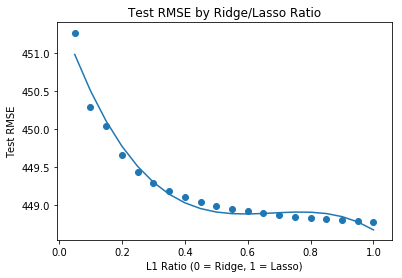

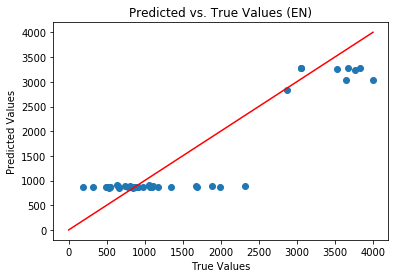

In [386]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_full, y_train, X_test_full, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

## LFP + OLD Split Standardize

In [387]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

In [388]:
new_ct["battery_index"] = new_ct["battery"].str[-2:].astype(int)

In [389]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
new_ct_full["Source"] = 1

In [390]:
if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))

In [391]:
all_model_features

['X.abs_min_discharge_capacity_difference_cycles_2:100',
 'X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'X.slope_discharge_capacity_cycle_number_2:100',
 'X.intercept_discharge_capacity_cycle_number_2:100',
 'X.discharge_capacity_cycle_2',
 'X.charge_time_cycles_1:5',
 'X.integrated_time_temperature_cycles_1:100',
 'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
 'X.max_discharge_capacity_difference',
 'X.abs_skew_discharge_capacity_difference_cycles_2:100',
 'Source']

In [392]:
t_ind = [i for i in range(0, len(new_ct_full), 2)]
ts_ind = [i for i in range(1, len(new_ct_full), 2)]
X_train_new = new_ct_full.loc[t_ind, all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0)
X_test_new = new_ct_full.loc[ts_ind, all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0)
y_train_new = new_ct.loc[X_train_new.index, y]
y_test_new = new_ct.loc[X_test_new.index, y] 

if standardized:
    X_train_new, X_test_new = standardize(
        X_train_new, 
        X_test_new,
    )

In [393]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

In [394]:
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
old_ct["Source"] = -1

In [395]:
if environ:
    old_ct["Temperature"] = 30
    old_ct["DOD"] = 100
    old_ct["Charge_rate"] = 4.8
    old_ct["Discharge_rate"] = 4

In [396]:
X_train_old = old_ct.loc[train_ind, all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0)
X_test_old = old_ct.loc[test_ind, all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0)
y_train_old = old_ct.loc[X_train_old.index, y]
y_test_old = old_ct.loc[X_test_old.index, y] 

if standardized:
    X_train_old, X_test_old = standardize(
        X_train_old, 
        X_test_old,
    )

In [397]:
X_train = X_train_old.append(X_train_new, ignore_index=True)
X_test = X_test_old.append(X_test_new, ignore_index=True)
y_train = y_train_old.append(y_train_new, ignore_index=True)
y_test = y_test_old.append(y_test_new, ignore_index=True)

In [398]:
#True if combining both the old data and new data
mix = True

source = "LFP+OLD+split"

cond = pd.Series({"ct": ct, "train_old_t_new": train_old_test_new, "time_temp_cycle":integrated_time_temp_cycles,
                  "log_y": log_transformation, "ir": ir, "standardized": standardized, "new+old":mix, "environ":environ, 
                  "source_v":dataset})

In [399]:
type(y_test) == pd.Series

True

### Variance Model

In [400]:
# Variance model
X_train_var = X_train[[variance_model_features]]

X_test_var = X_test[[variance_model_features]]

model_name = "Variance"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

Variance Basic Linear Regression Model
Training RMSE:  1109.8568666087406
Test RMSE:  947.7690236577811
Mean % Train Error:  0.421640036037926
Mean % Test Error:  0.3693595487810612


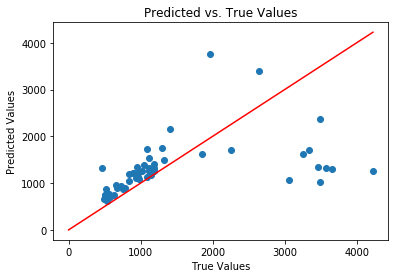

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  946.4164132677585
Test MAPE:  0.3693131251684185


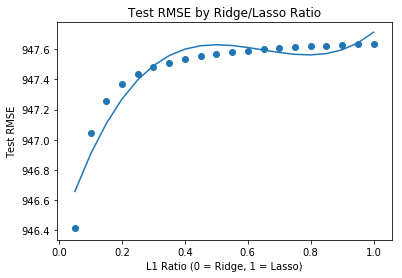

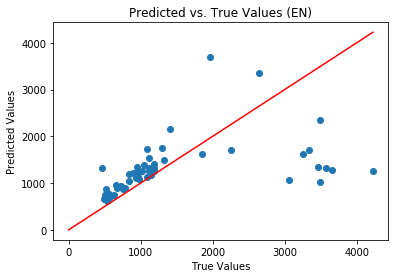

In [401]:
print("Variance Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_var, y_train, X_test_var, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

### Discharge Model

In [402]:
# discharge model
X_train_dis = X_train[discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

X_test_dis = X_test[discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

model_name = "Discharge"

Discharge Basic Linear Regression Model
Training RMSE:  1039.711998798801
Test RMSE:  981.4030225991858
Mean % Train Error:  0.35864512353510763
Mean % Test Error:  0.362591790760197


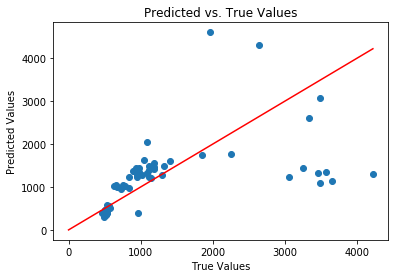

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  973.5763111558673
Test MAPE:  0.3497762671385492


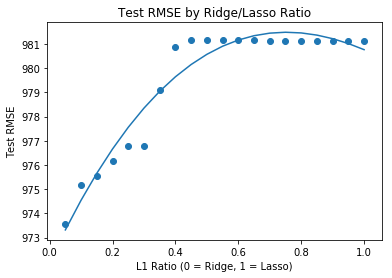

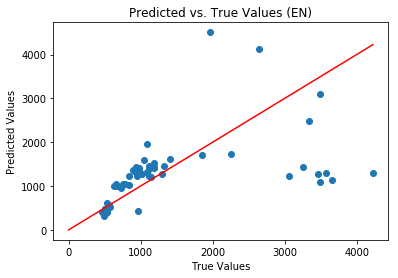

In [403]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_dis, y_train, X_test_dis, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

### Full Model

In [404]:
# full model
X_train_full = X_train[full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

X_test_full = X_test[full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

model_name = "Full"

# if log_transformation:
#     y_train = np.log(y_train)
#     y_test = np.log(y_test)

Discharge Basic Linear Regression Model
Training RMSE:  1038.0866885836886
Test RMSE:  954.5958915453117
Mean % Train Error:  0.37811893767388327
Mean % Test Error:  0.3697742364323007


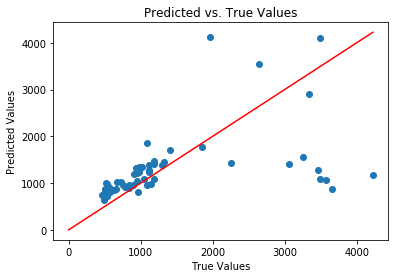

Elastic Net Model
l1_ratio = 0.05
Test RMSE:  945.3222561040135
Test MAPE:  0.4093810373782119


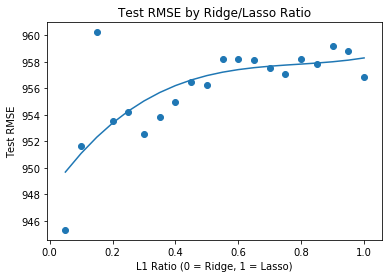

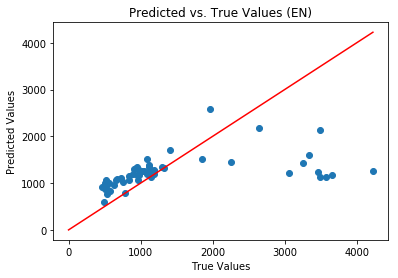

In [405]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred, elasticnet = run_models(X_train_full, y_train, X_test_full, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "L_mape": rmses[2], 
                                                      "EN_mape":rmses[3], "model":model_name, "data":source, 
                                                      "coef":elasticnet.coef_})),
                               ignore_index=True)

In [406]:
results_df

,EN_mape,EN_rmse,L_mape,L_rmse,coef,ct,data,environ,ir,log_y,model,new+old,standardized,time_temp_cycle,train_old_t_new,source_v
0,0.202551,756.601364,0.172613,435.787696,[-8.12445755357174e-18],1.0,NCA,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
1,0.151340,321.745791,0.330654,724.418249,"[-0.052398868048105764, -0.0, -0.0, -0.0, 0.0,...",1.0,NCA,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
2,0.201796,706.649367,0.507998,1149.765440,"[-0.007374690818696963, -0.0, -0.0, -0.0, 0.0,...",1.0,NCA,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
3,0.387334,1493.768468,0.386985,1490.910518,[-0.19065150630020095],1.0,NMC,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
4,0.195836,615.954509,0.241999,693.530273,"[0.0, -0.0, 0.0, 0.0, 0.029086967804971935, 0....",1.0,NMC,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
5,0.159628,555.837900,0.207779,1362.525761,"[-0.030931559001205502, -0.024145899755950155,...",1.0,NMC,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
6,0.176383,641.162957,0.148546,533.879994,[0.0],1.0,LFP,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,NaN
7,0.128313,487.012917,0.435354,2101.922985,"[0.0711628404993017, -0.0, -0.0762756249351698...",1.0,LFP,1.0,1.0,1.0,Discharge,1.0,1.0,1.0,0.0,NaN
8,0.116586,561.132427,0.447694,1956.670634,"[0.08165635734541497, 0.14563245030628708, -0....",1.0,LFP,1.0,1.0,1.0,Full,1.0,1.0,1.0,0.0,NaN
9,0.493960,682.233425,0.505741,679.441792,[4.212861725379188e-18],1.0,NCA+OLD,1.0,1.0,1.0,Variance,1.0,1.0,1.0,0.0,1.0


In [407]:
results_df.data.apply(lambda x: "+" in x)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
40     True
41     True
Name: data, dtype: bool

In [413]:
results_df[(results_df.data.apply(lambda x: "+" in x)) & (results_df.model != "Variance") & (results_df.data != "LFP+OLD+split")].groupby(["data", "model", "environ"]).describe().iloc[:, [1, 17]]

EN_mape    L_mape
                               mean      mean
data    model     environ                    
LFP+OLD Discharge 0.0      0.294656  0.280869
                  1.0      0.223119  0.200267
        Full      0.0      0.350654  0.247816
                  1.0      0.350655  0.187219
NCA+OLD Discharge 0.0      0.127581  0.130981
                  1.0      0.263393  0.208565
        Full      0.0      0.126930  0.131951
                  1.0      0.281124  0.237401
NMC+OLD Discharge 0.0      0.176171  0.159417
                  1.0      0.168833  0.159228
        Full      0.0      0.212269  0.182464
                  1.0      0.212268  0.192409

In [409]:
stop

NameError: name 'stop' is not defined

In [ ]:
results_df

In [ ]:
results_df

In [ ]:
coefs_full = (pd.DataFrame(results_df[results_df.model == "Full"].loc[:, "coef"].to_list(),
                           columns = full_model_features))# + ["X.integrated_time_temperature_cycles_1:100"]))
coefs_full["data"] = results_df[results_df.model == "Full"].loc[:, "data"].reset_index().drop("index", axis=1)
coefs_full["EN_mape"] = results_df[results_df.model == "Full"].loc[:, "EN_mape"].reset_index().drop("index", axis=1)

In [ ]:
coefs_full

In [ ]:
coefs_dis = (pd.DataFrame(results_df[results_df.model == "Discharge"].loc[:, "coef"].to_list(),
                           columns = discharge_model_features))# + ["X.integrated_time_temperature_cycles_1:100"]))
coefs_dis["data"] = results_df[results_df.model == "Discharge"].loc[:, "data"].reset_index().drop("index", axis=1)
coefs_dis["EN_mape"] = results_df[results_df.model == "Discharge"].loc[:, "EN_mape"].reset_index().drop("index", axis=1)

In [ ]:
coefs_dis.drop(index=[3, 4, 5], axis=0)

LOG + TIME_INTEGRATED

In [ ]:
plot_df = results_df[(results_df.log_y == 1.0) & (results_df.time_temp_cycle == 1.0)].set_index("data").sort_index(axis=0)
plot_df

In [ ]:
plot_df.reset_index().set_index("data").loc["NCA", "EN_rmse"].values

In [ ]:
custom_dict = {'Variance': 0, 'Discharge': 1, 'Full': 2} 
plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).loc["NCA", "EN_rmse"].values

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["NCA", "NMC", "LFP"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NCA", "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NMC", "EN_rmse"].values), width, label=data[1])
rects3 = ax.bar(x+width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["LFP", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1550])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + time_integrated

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["NCA+OLD", "NMC+OLD", "LFP+OLD"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NCA+OLD", "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NMC+OLD", "EN_rmse"].values), width, label=data[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["LFP+OLD", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1550])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + time_integrated

LOG + NO TIME INTEGRATED

In [ ]:
plot_df = results_df[(results_df.log_y == 1.0) & (results_df.time_temp_cycle == 0.0)].set_index("data").sort_index(axis=0)
plot_df

In [ ]:
plot_df.reset_index().set_index("data").loc["NCA", "EN_rmse"].values

In [ ]:
custom_dict = {'Variance': 0, 'Discharge': 1, 'Full': 2} 
plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).loc["NCA", "EN_rmse"].values

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["NCA", "NMC", "LFP"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NCA", "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NMC", "EN_rmse"].values), width, label=data[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["LFP", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1550])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["NCA+OLD", "NMC+OLD", "LFP+OLD"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NCA+OLD", "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NMC+OLD", "EN_rmse"].values), width, label=data[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["LFP+OLD", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1550])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

NO LOG + NO TIME_INTEGRATED

In [ ]:
plot_df = results_df[(results_df.log_y == 0.0) & (results_df.time_temp_cycle == 0.0)].set_index("data").sort_index(axis=0)
plot_df

In [ ]:
plot_df.reset_index().set_index("data").loc["NCA", "EN_rmse"].values

In [ ]:
custom_dict = {'Variance': 0, 'Discharge': 1, 'Full': 2} 
plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).loc["NCA", "EN_rmse"].values

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["NCA", "NMC", "LFP"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NCA", "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NMC", "EN_rmse"].values), width, label=data[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["LFP", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1550])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + time_integrated

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["NCA+OLD", "NMC+OLD", "LFP+OLD"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NCA+OLD", "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NMC+OLD", "EN_rmse"].values), width, label=data[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["LFP+OLD", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1550])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + time_integrated

NO LOG + TIME INTEGRATED

In [ ]:
plot_df = results_df[(results_df.log_y == 0.0) & (results_df.time_temp_cycle == 1.0)].set_index("data").sort_index(axis=0)
plot_df

In [ ]:
plot_df.reset_index().set_index("data").loc["NCA", "EN_rmse"].values

In [ ]:
custom_dict = {'Variance': 0, 'Discharge': 1, 'Full': 2} 
plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).loc["NCA", "EN_rmse"].values

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["NCA", "NMC", "LFP"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NCA", "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NMC", "EN_rmse"].values), width, label=data[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["LFP", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1550])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["NCA+OLD", "NMC+OLD", "LFP_OLD"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NCA+OLD", "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["NMC+OLD", "EN_rmse"].values), width, label=data[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
                              loc["LFP+OLD", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1550])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

In [ ]:
results_df.merge(results_df[results_df["model"] == "Full"].groupby("data")["EN_rmse"].min(), on="EN_rmse")

In [ ]:
## NCA + OLD DATA

new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA_NCA.csv")
new_df = pd.read_csv(path + "NewData/NCABatteries.csv")

new_ct["battery_index"] = new_ct["battery"].str[-9:-7].astype(int)

new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

#Removing internal_resistance features for models with new data
# if ir:
# #     full_model_features.remove('X.min_internal_resistance_cycles_2:100')
# #     full_model_features.remove('X.internal_resistance_difference_cycles_2:100')
    
#     if standardized:
#         all_model_features.remove('X.min_internal_resistance_cycles_2:100')
#         all_model_features.remove('X.internal_resistance_difference_cycles_2:100')

old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

full_df = old_ct.append(new_ct_full, ignore_index=True)
#full_data = full_data.reset_index()

if standardized:
    full_df[all_model_features] = standardize(
        full_df[all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0)
    )

full_df.head()

full_df.columns

#True if combining both the old data and new data
mix = True

train_old_test_new = False
source = "NCA+OLD"

cond = pd.Series({"ct": ct, "train_old_t_new": train_old_test_new, "time_temp_cycle":integrated_time_temp_cycles,
                  "log_y": log_transformation, "ir": ir, "standardized": standardized, "new+old":mix, "environ":environ, 
                  "source_v":dataset})

In [ ]:
plot_df = results_df[(results_df.log_y == 1.0) & (results_df.time_temp_cycle == 0.0) & (results_df.ir == 0.0)].set_index("data").sort_index(axis=0)
plot_df

In [ ]:
custom_dict = {'Variance': 0, 'Discharge': 1, 'Full': 2} 

In [ ]:
(plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).loc[1.0, "EN_rmse"].values)

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["No Scaler", "Standard Scaler"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, (plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).
                            loc[0.0, "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x + width/2, (plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).
                            loc[1.0, "EN_rmse"].values), width, label=data[1])

# rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
#                               loc["LFP", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('Test RMSE by Model and Scaler (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,600])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

LFP + OLD

In [ ]:
plot_df = results_df[(results_df.log_y == 1.0) & (results_df.time_temp_cycle == 0.0) & (results_df.ir == 0.0) & (results_df["data"] == "LFP+OLD")].sort_index(axis=0)
plot_df

In [ ]:
custom_dict = {'Variance': 0, 'Discharge': 1, 'Full': 2} 

In [ ]:
(plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).loc[1.0, "EN_rmse"].values)

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["No Scaler", "Standard Scaler"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, (plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).
                            loc[0.0, "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x + width/2, (plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).
                            loc[1.0, "EN_rmse"].values), width, label=data[1])

# rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
#                               loc["LFP", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('Test RMSE by Model and Scaler (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,1200])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

## OLD

In [ ]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")
source = "OLD"

In [ ]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

In [ ]:
new_ct["battery_index"] = new_ct["battery"].str[-2:].astype(int)

In [ ]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, on = "battery_index")
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [ ]:
cond = pd.Series({"ct": ct, "train_old_t_new": train_old_test_new, "time_temp_cycle":integrated_time_temp_cycles,
                  "log_y": log_transformation, "ir": ir, "standardized": standardized, "new+old":mix, "environ":environ})

In [ ]:
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [ ]:
train_ind = [i for i in range(0, old_ct.shape[0], 2)]
test_ind = [i for i in range(1, old_ct.shape[0], 2)]

# Note:

When running the code below, the rows with NA are not removed, but then every value in those rows is NA. In order to preserve the same train/test indices, I'll just let all values in the row be NA and remove them when it comes to the train/test subsets

Also unrelated, but we may want to deal with the fact that there's a lot of 0's in columns that are otherwise negative

In [ ]:
old_ct.charge_throughput.plot.hist()

### Variance Model

In [ ]:
# Variance model
X_train_var = old_ct.iloc[train_ind][[variance_model_features]]
X_train_var = X_train_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = old_ct.iloc[X_train_var.index][[y]]

X_test_var = old_ct.iloc[test_ind][[variance_model_features]]
X_test_var = X_test_var.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = old_ct.iloc[X_test_var.index][[y]]

if standardized:
    X_train_var, X_test_var = standardize(
        X_train_var[variance_model_features], 
        X_test_var[variance_model_features], True
    )

model_name = "Variance"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [ ]:
print("Variance Basic Linear Regression Model")
rmses, y_pred = run_models(X_train_var, y_train, X_test_var, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "model":model_name, "data":source})),
                               ignore_index=True)

### Discharge Model

In [ ]:
# discharge model
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_dis = X_train_dis.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = old_ct.iloc[X_train_dis.index][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_dis = X_test_dis.replace([np.inf, -np.inf,  0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = old_ct.iloc[X_test_dis.index][[y]]

if standardized:
    X_train_dis, X_test_dis = standardize(
        X_train_dis[discharge_model_features], 
        X_test_dis[discharge_model_features],
    )

model_name = "Discharge"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [ ]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred = run_models(X_train_dis, y_train, X_test_dis, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "model":model_name, "data":source})),
                               ignore_index=True)

### Full Model

In [ ]:
# full model
X_train_full = old_ct.iloc[train_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_train_full = X_train_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_train = old_ct.iloc[X_train_full.index][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features]#.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
X_test_full = X_test_full.replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0) #Can delete if we find a solution to the issue presented above
y_test = old_ct.iloc[X_test_full.index][[y]]

if standardized:
    X_train_full, X_test_full = standardize(
        X_train_full[full_model_features], 
        X_test_full[full_model_features],
    )

model_name = "Full"

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [ ]:
print("Discharge Basic Linear Regression Model")
rmses, y_pred = run_models(X_train_full, y_train, X_test_full, y_test, log_transformation)

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmses[0], "EN_rmse":rmses[1], "model":model_name, "data":source})),
                               ignore_index=True)

In [ ]:
results_df

LFP + OLD

In [ ]:
plot_df = results_df[(results_df.log_y == 1.0) & (results_df.time_temp_cycle == 0.0) & (results_df.ir == 1.0) & (results_df["data"] == "OLD")].sort_index(axis=0)
plot_df

In [ ]:
custom_dict = {'Variance': 0, 'Discharge': 1, 'Full': 2} 

In [ ]:
(plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).loc[1.0, "EN_rmse"].values)

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["No Scaler", "Standard Scaler"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, (plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).
                            loc[0.0, "EN_rmse"].values), width, label=data[0])
rects2 = ax.bar(x + width/2, (plot_df.reset_index().set_index("standardized").sort_values("model", key=lambda x: x.map(custom_dict)).
                            loc[1.0, "EN_rmse"].values), width, label=data[1])

# rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("data").sort_values("model", key=lambda x: x.map(custom_dict)).
#                               loc["LFP", "EN_rmse"].values), width, label=data[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('Test RMSE by Model and Scaler (EN)')
ax.set_xticks(x)
ax.set_xticklabels(kind)
ax.set_ylim([0,300])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated